In [1]:
from copy import copy
import math
import os
from pathlib import Path
import pickle
from adjustText import adjust_text
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from citylearn.cost_function import CostFunction
from experiment import preliminary_setup, set_brief_summary, set_detailed_summary

In [66]:
set_detailed_summary('tymur_prorochenko')

Reading 1/1


In [2]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
SMALL_FONT = 12
MEDIUM_FONT = 14
LARGE_FONT = 16
plt.rc('font',size=SMALL_FONT) # controls default text sizes
plt.rc('axes',titlesize=MEDIUM_FONT) # fontsize of the axes title
plt.rc('axes',labelsize=SMALL_FONT) # fontsize of the x and y labels
plt.rc('xtick',labelsize=SMALL_FONT) # fontsize of the tick labels
plt.rc('ytick',labelsize=SMALL_FONT) # fontsize of the tick labels
plt.rc('legend',fontsize=SMALL_FONT) # legend fontsize
plt.rc('figure',titlesize=LARGE_FONT) # fontsize of the figure title

TIMESTAMPS = pd.DataFrame(pd.date_range('2016-08-01 00:00:00','2017-07-31 23:00:00',freq='H'),columns=['timestamp'])
TIMESTAMPS['time_step'] = TIMESTAMPS.index

In [7]:
def get_brief_summary(experiment, building_level=False):
    grid = pd.read_csv(os.path.join(KWARGS['misc_directory'],f'{experiment}_grid.csv'))
    summary = pd.read_csv(os.path.join(KWARGS['summary_directory'],f'{experiment}_brief.csv'))
    summary = grid.merge(summary,on='simulation_id',how='inner')

    # score summary
    columns = [
        'net_electricity_consumption_sum',
        'net_electricity_consumption_emission_sum',
        'net_electricity_consumption_price_sum',
        'net_electricity_consumption_without_storage_sum',
        'net_electricity_consumption_emission_without_storage_sum',
        'net_electricity_consumption_price_without_storage_sum',
        'reward_sum',
    ]
    groupby_columns = ['group','simulation_id','episode']
    groupby_columns += ['building_id'] if building_level else []
    score_summary = summary.copy()
    score_summary[columns[1:-1]] = score_summary[columns[1:-1]].clip(lower=0)
    score_summary = summary.groupby(groupby_columns)[columns].sum().reset_index()
    score_summary['consumption_score'] = score_summary['net_electricity_consumption_sum']\
        /score_summary['net_electricity_consumption_without_storage_sum']
    score_summary['price_score'] = score_summary['net_electricity_consumption_price_sum']\
        /score_summary['net_electricity_consumption_price_without_storage_sum']
    score_summary['emission_score'] = score_summary['net_electricity_consumption_emission_sum']\
        /score_summary['net_electricity_consumption_emission_without_storage_sum']
    score_columns = ['consumption_score','price_score','emission_score']
    groupby_columns.remove('simulation_id')
    score_summary = score_summary.groupby(groupby_columns)[score_columns + ['reward_sum']].mean().reset_index()
    score_summary['average_score'] = score_summary[score_columns].mean(axis=1)
    score_summary['average_price_and_emission_score'] = score_summary[['price_score','emission_score']].mean(axis=1)

    return grid, summary, score_summary

def get_detailed_summary(experiment, building_level=False):
    grid = pd.read_csv(os.path.join(KWARGS['misc_directory'],f'{experiment}_grid.csv'))
    summary = pd.read_csv(os.path.join(KWARGS['summary_directory'],f'{experiment}_detailed.csv'))
    summary = grid.merge(summary,on='simulation_id',how='inner')
    columns = [
        'net_electricity_consumption',
        'net_electricity_consumption_emission',
        'net_electricity_consumption_price',
        'net_electricity_consumption_without_storage',
        'net_electricity_consumption_emission_without_storage',
        'net_electricity_consumption_price_without_storage',
        'net_electricity_consumption_without_storage_and_pv',
        'electrical_storage_soc',
        'electrical_storage_electricity_consumption',
    ]
    groupby_columns = ['group','simulation_id','episode','time_step']
    groupby_columns += ['building_id'] if building_level else []
    summary = summary.groupby(groupby_columns)[columns].sum().reset_index()
    groupby_columns.remove('simulation_id')
    summary = summary.groupby(groupby_columns)[columns].mean().reset_index()
    summary = summary.merge(TIMESTAMPS,on='time_step',how='left')

    return summary
   

def plot_score_trajectory(plot_data,fig_groupby_columns,ax_groupby_columns,round_number=None):
    row_count = 1
    column_count = 3
    ylim = (
        plot_data[['average_price_and_emission_score','price_score','emission_score']].min().min(),
        plot_data[['average_price_and_emission_score','price_score','emission_score']].max().max()
    )

    for fig_names, type_group in plot_data.groupby(fig_groupby_columns):
        fig, axs = plt.subplots(row_count,column_count,figsize=(4*column_count,2.0*row_count),sharey=True)
        
        for ax_names, simulation_id_group in type_group.groupby(ax_groupby_columns):
            if round_number:
                label = str(tuple([round(n,round_number) for n in ax_names]))
            else:
                label = str(ax_names)

            simulation_id_group = simulation_id_group.sort_values('episode')

            # cost
            x, y = simulation_id_group['episode'], simulation_id_group['price_score']
            axs[0].plot(x,y,label=label)
            axs[0].set_title('Price')

            # carbon_emission
            x, y = simulation_id_group['episode'], simulation_id_group['emission_score']
            axs[1].plot(x,y,label=label)
            axs[1].set_title('Carbon emission')

            # average
            x, y = simulation_id_group['episode'], simulation_id_group['average_price_and_emission_score']
            axs[2].plot(x,y,label=label)
            axs[2].set_title('Average')

        for i, ax in enumerate(fig.axes):
            ax.set_xlabel('Episode')
            ax.set_ylim(ylim)
            ax.axhline(1.0,color='black',linestyle='--')

            if i == 0:
                ax.legend(
                    bbox_to_anchor=(0.5,-0.1),
                    loc='upper center', 
                    bbox_transform=fig.transFigure,
                    framealpha=0,
                    ncol=7
                )
            else:
                pass
        
        fig.suptitle(f'{fig_names}',y=1.10)
        plt.show()

# Reward Design

In [12]:
reward_design_grid, reward_design_summary, reward_design_score_summary = get_brief_summary('reward_design')
# reward_design_grid['e'] = reward_design_grid['exponent']
# reward_design_grid['w_1'] = reward_design_grid['weight']
# reward_design_grid['w_2'] = 1.0 - reward_design_grid['weight']
metadata = reward_design_grid[[
    'group','type','carbon_emission_exponent','electricity_exponent','electricity_price_exponent','electricity_price_weight']].drop_duplicates()
reward_design_score_summary = metadata.merge(reward_design_score_summary,on='group',how='left')

# # ordered average score by last episode 
# display(reward_design_score_summary[reward_design_score_summary['episode']==9][[
#     'group','type','e','w_1','w_2','episode',
#     'average_score','average_price_and_emission_score',
#     'price_score','emission_score','consumption_score',
# ]].sort_values('average_price_and_emission_score').head(10))
display(reward_design_score_summary[reward_design_score_summary['episode']==10][[
    'group','type','carbon_emission_exponent','electricity_exponent','electricity_price_exponent','electricity_price_weight',
    'average_price_and_emission_score','price_score','emission_score','consumption_score',
]].sort_values('average_price_and_emission_score').head(30))

,group,type,carbon_emission_exponent,electricity_exponent,electricity_price_exponent,electricity_price_weight,average_price_and_emission_score,price_score,emission_score,consumption_score
296,54,reward.AdditiveReward,1.0,NaN,2.0,1.0,0.802781,0.711452,0.894110,1.083048
263,51,reward.AdditiveReward,2.0,NaN,2.0,0.8,0.803371,0.714279,0.892463,1.083351
307,55,reward.AdditiveReward,2.0,NaN,2.0,1.0,0.803446,0.714481,0.892412,1.083033
252,50,reward.AdditiveReward,1.0,NaN,2.0,0.8,0.804640,0.718566,0.890713,1.080513
219,47,reward.AdditiveReward,2.0,NaN,2.0,0.6,0.805488,0.721126,0.889850,1.086007
175,43,reward.AdditiveReward,2.0,NaN,2.0,0.5,0.808406,0.729921,0.886892,1.088369
274,52,reward.AdditiveReward,1.0,NaN,1.0,1.0,0.809081,0.726623,0.891540,1.075733
241,49,reward.AdditiveReward,2.0,NaN,1.0,0.8,0.810459,0.729893,0.891024,1.074358
208,46,reward.AdditiveReward,1.0,NaN,2.0,0.6,0.810487,0.736956,0.884018,1.074809
285,53,reward.AdditiveReward,2.0,NaN,1.0,1.0,0.811419,0.730279,0.892560,1.074628


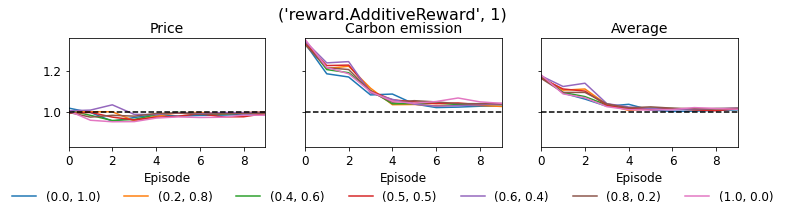

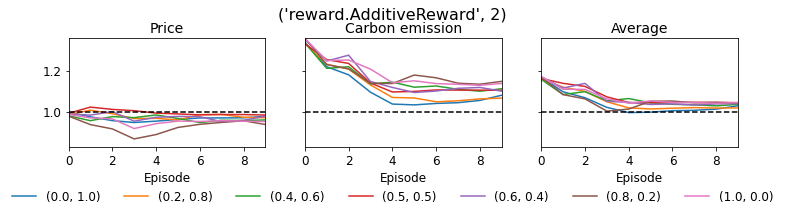

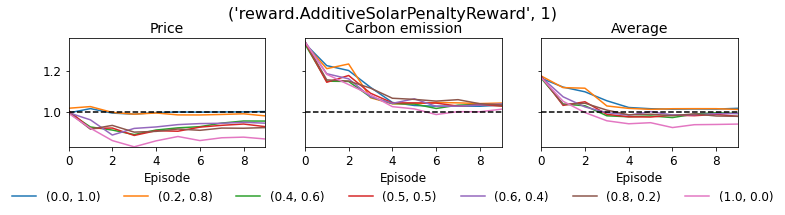

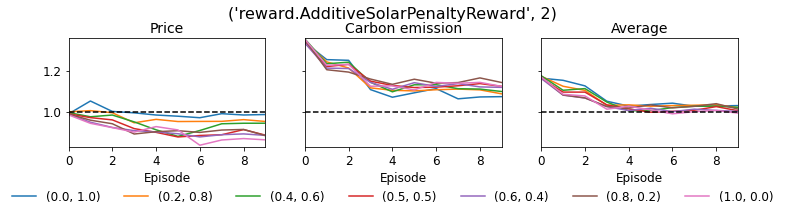

In [197]:
# score trajectory
plot_data = reward_design_score_summary.copy()
fig_groupby_columns = ['type','e']
ax_groupby_columns = ['w_1','w_2']
plot_score_trajectory(plot_data,fig_groupby_columns,ax_groupby_columns,round_number=1)

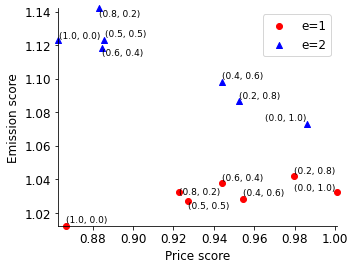

In [198]:
# emission - price scattear
fig, ax = plt.subplots(1,1,figsize=(5,4))
plot_data = reward_design_score_summary[
    (reward_design_score_summary['type']=='reward.AdditiveSolarPenaltyReward')
    &(reward_design_score_summary['episode']==9)
].copy()
colors = ['red','blue']
markers = ['o','^']
texts = []

for i, (e, plot_data) in enumerate(plot_data.groupby('e')):
    x, y = plot_data['price_score'], plot_data['emission_score']
    lim = (min(x.tolist() + y.tolist()), max(x.tolist() + y.tolist()))
    ax.scatter(x,y,clip_on=False,color=colors[i],label=f'e={e}',marker=markers[i])

    for x_, y_, w_1, w_2 in plot_data[['price_score','emission_score','w_1','w_2']].to_records(index=False):
        texts.append(ax.text(x_,y_,f'({round(w_1,1)}, {round(w_2,1)})',ha='center',va='center',color='black',fontsize=9.0))


ax.spines[['right','top']].set_visible(False)
adjust_text(texts)
ax.set_xlabel('Price score')
ax.set_ylabel('Emission score')
ax.legend()
filepath = os.path.join(KWARGS['figure_directory'],'reward_design_scatter.pdf')
plt.savefig(filepath,transparent=True,bbox_inches='tight')
plt.show()

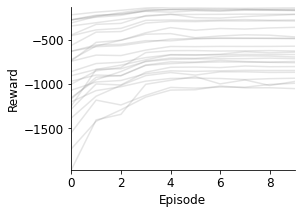

In [201]:
# reward trajectory
plot_data = reward_design_score_summary.copy()
fig, ax = plt.subplots(1,1,figsize=(4,3))
linestyle = '-'

for i, (building_id, building_data) in enumerate(plot_data.groupby('group')):
    linestyle = '--' if i > 9 else linestyle
    building_data = building_data.sort_values('episode')
    x, y = building_data['episode'], building_data['reward_sum']
    ax.plot(x,y,label=building_id,linestyle='-',color='grey',alpha=0.2)

ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.spines[['right','top']].set_visible(False)
# ax.legend(
#     title='Building ID',
#     bbox_to_anchor=(1.0,1.0), 
#     bbox_transform=fig.transFigure,
#     framealpha=0,
#     ncol=2
# )
plt.show()

# Hyperparameter Design

In [208]:
hyperparameter_design_grid, hyperparameter_design_summary, hyperparameter_design_score_summary = get_brief_summary('hyperparameter_design')
metadata = hyperparameter_design_grid[['group','discount','tau','lr','alpha']].drop_duplicates()
hyperparameter_design_score_summary = metadata.merge(hyperparameter_design_score_summary,on='group',how='left')

# ordered average score by last episode 
display(hyperparameter_design_score_summary[hyperparameter_design_score_summary['episode']==9][[
    'group','discount','tau','lr','alpha','episode','reward_sum',
    'average_score','average_price_and_emission_score',
    'price_score','emission_score','consumption_score',
]].sort_values('average_price_and_emission_score').head(10))

,group,discount,tau,lr,alpha,episode,reward_sum,average_score,average_price_and_emission_score,price_score,emission_score,consumption_score
279,74,0.99,0.0500,0.00005,0.8,9,-808.870958,0.974290,0.960571,0.873686,1.047457,1.001728
349,67,0.99,0.0050,0.00050,0.5,9,-805.463909,0.977921,0.966342,0.902535,1.030149,1.001080
459,14,0.90,0.0050,0.00050,0.8,9,-809.074991,0.984629,0.976611,0.915077,1.038146,1.000664
439,16,0.90,0.0050,0.00500,0.5,9,-806.854413,0.987962,0.981407,0.924712,1.038101,1.001072
139,46,0.95,0.0500,0.00005,0.5,9,-822.924859,0.988193,0.981951,0.905818,1.058085,1.000675
429,17,0.90,0.0050,0.00500,0.8,9,-801.129725,0.989527,0.983672,0.936526,1.030818,1.001235
749,26,0.90,0.0500,0.00500,0.8,9,-809.540796,0.989953,0.984359,0.928248,1.040471,1.001141
669,35,0.95,0.0005,0.00500,0.8,9,-805.500904,0.990640,0.985229,0.936383,1.034076,1.001462
529,7,0.90,0.0005,0.00500,0.5,9,-812.673276,0.991017,0.985966,0.928495,1.043437,1.001119
199,62,0.99,0.0005,0.00500,0.8,9,-789.776982,0.991417,0.986442,0.962608,1.010276,1.001365


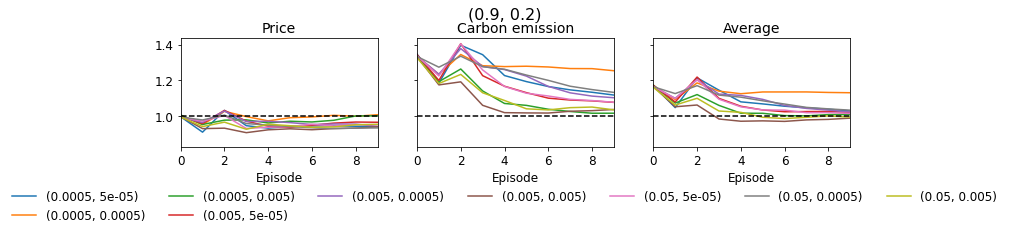

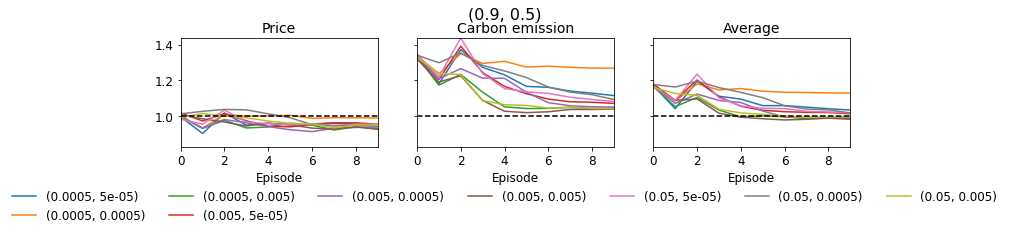

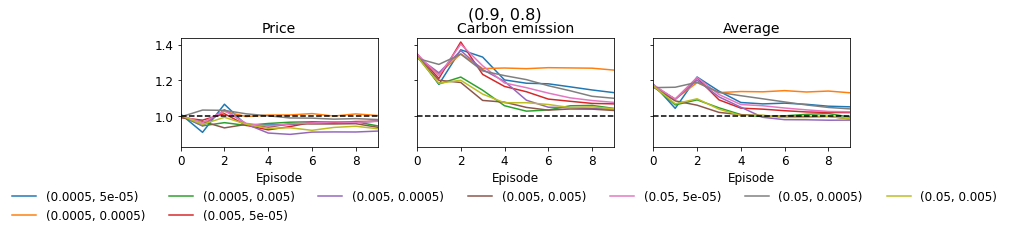

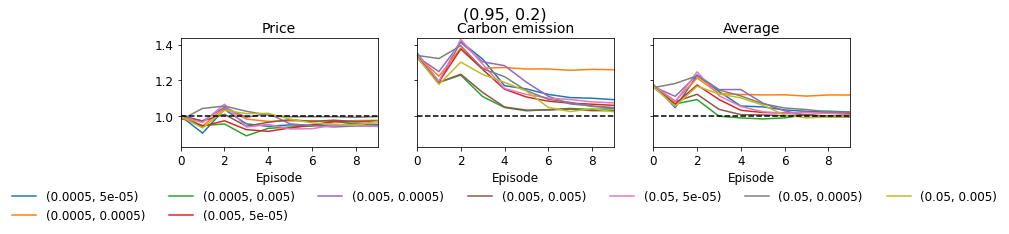

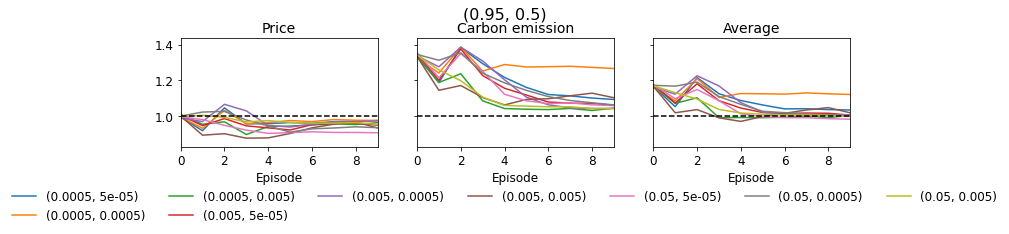

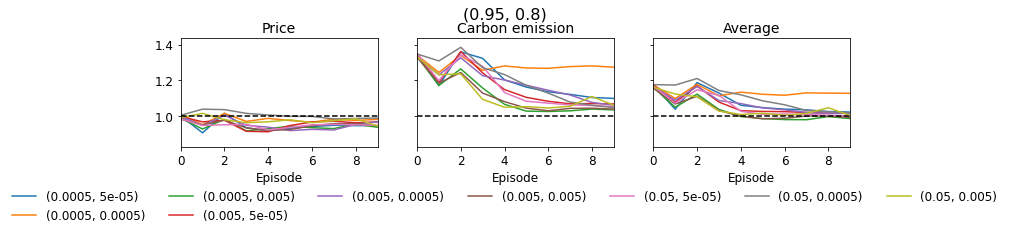

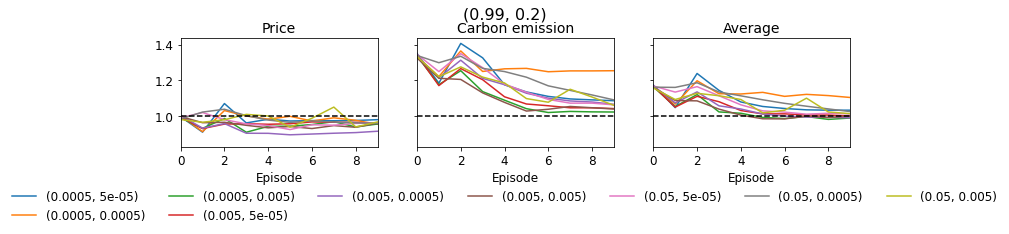

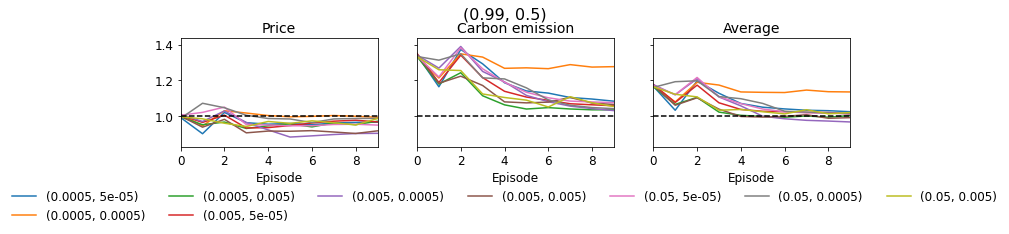

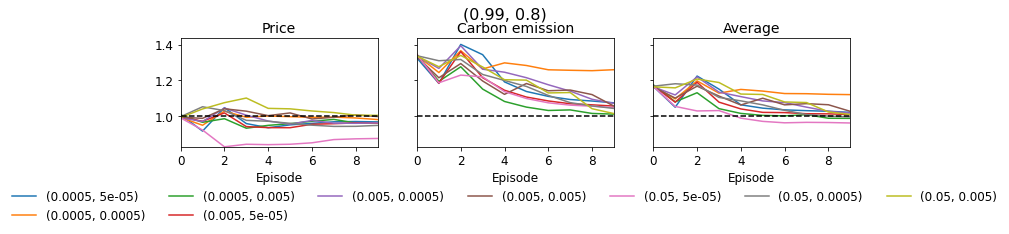

In [209]:
# score trajectory
plot_data = hyperparameter_design_score_summary.copy()
fig_groupby_columns = ['discount','alpha']
ax_groupby_columns = ['tau','lr']
plot_score_trajectory(plot_data,fig_groupby_columns,ax_groupby_columns,round_number=None)

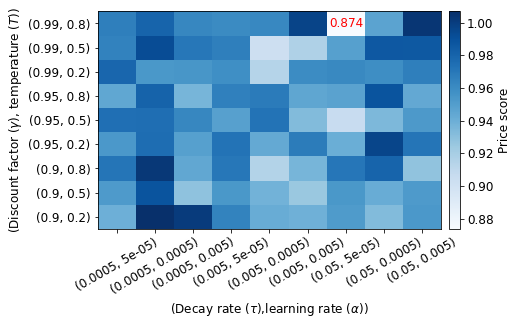

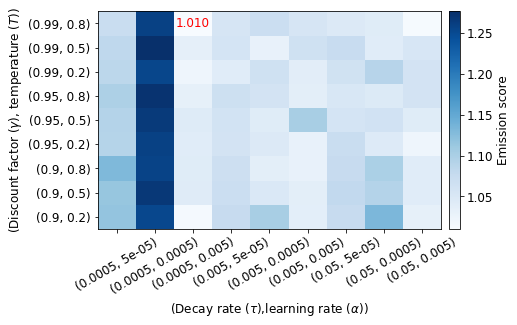

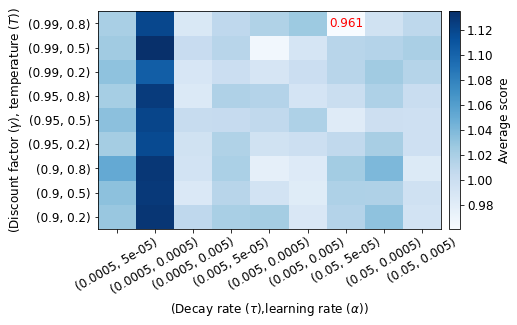

In [210]:
# final episode heat map
cmap = 'Blues'
cmap = copy(cm.get_cmap(cmap))
cmap.set_bad(color='grey')
shading = 'nearest'
cb_fraction = 0.1
cb_pad = 0.02
labels = ['Price', 'Emission', 'Average']
columns = ['price_score','emission_score','average_price_and_emission_score']

for c, l in zip(columns,labels):
    plot_data = hyperparameter_design_score_summary[
        hyperparameter_design_score_summary['episode']==9
    ].pivot_table(index=['discount','alpha'],columns=['tau','lr'],values=c)
    x, y, z = plot_data.columns.tolist(), plot_data.index, plot_data.values
    x_labels = [str(x_) for x_ in x]
    # x_labels = [x_.split(',')[0] + '\n' +  x_.split(',')[1] for x_ in x_labels]
    y_labels = [str(y_) for y_ in y]
    x = list(range(len(x)))
    y = list(range(len(y)))
    fig, ax = plt.subplots(1,1,figsize=(7,4))
    pcm = ax.pcolormesh(x,y,z,shading=shading,cmap=cmap)
    ax.set_xlabel(r'(Decay rate ($\tau$),learning rate ($\alpha$))')
    ax.set_ylabel(r'(Discount factor ($\gamma$), temperature ($T$))')
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)

    for (i, j), v in np.ndenumerate(plot_data):
        if v == z.min():
            ax.text(j,i,f'{v:0.3f}',ha='center',va='center',color='red',fontsize=12)
        else:
            continue

    ax.tick_params('x',which='both',rotation=30)
    _ = fig.colorbar(pcm,ax=ax,fraction=0.1,pad=cb_pad,label=f'{l} score')
    filepath = os.path.join(KWARGS['figure_directory'],f'hyperparameter_design_{l.lower()}_heat_map.pdf')
    plt.savefig(filepath,transparent=True,bbox_inches='tight')
    plt.show()

# RBC Validation

In [211]:
# RBC Validation
# read actual battery consumption
battery_data = pd.read_csv(os.path.join(KWARGS['misc_directory'],'battery_electricity_consumption.csv'))
battery_data.columns = ['timestamp','building_id','actual_electrical_storage_electricity_consumption']
buildings = [2,3,6,7,8,9]
battery_data = battery_data[battery_data['building_id'].isin(buildings)]
battery_data['timestamp'] = pd.to_datetime(battery_data['timestamp'])
battery_data['building_id'] = battery_data['building_id'].map(lambda x: f'Building_{x}')
timestamps = pd.DataFrame({'timestamp':battery_data['timestamp'].unique()})

# read simulation data
rbc_validation_grid_filepath = os.path.join(KWARGS['misc_directory'],'rbc_validation_grid.csv')
rbc_validation_grid = pd.read_csv(rbc_validation_grid_filepath)
rbc_validation_simulations = []

for simulation_id in rbc_validation_grid['simulation_id'].tolist():
    filepath = os.path.join(KWARGS['result_directory'],f'{simulation_id}_episode_0.pkl')
    
    with (open(filepath, 'rb')) as openfile:
        env = pickle.load(openfile)

    for b in env.buildings:
        data = pd.DataFrame({
            'simulation_net_electricity_consumption':b.net_electricity_consumption,
            'simulation_net_electricity_consumption_price':b.net_electricity_consumption_price,
            'simulation_net_electricity_consumption_emission':b.net_electricity_consumption_emission,
            'simulation_electrical_storage_net_electricity_consumption':b.electrical_storage.electricity_consumption,
        })
        data['building_id'] = b.name
        data['timestamp'] = timestamps
        data['simulation_id'] = simulation_id
        rbc_validation_simulations.append(data)

rbc_validation_simulations = pd.concat(rbc_validation_simulations,ignore_index=True)
rbc_validation_simulations = rbc_validation_simulations.merge(rbc_validation_grid,on='simulation_id',how='inner')
rbc_validation_simulations = rbc_validation_simulations.merge(battery_data,on=['building_id','timestamp'],how='inner')
rbc_validation_simulations['error'] =  rbc_validation_simulations['simulation_electrical_storage_net_electricity_consumption'] - rbc_validation_simulations['actual_electrical_storage_electricity_consumption']
rbc_validation_simulations['ratio'] =  rbc_validation_simulations['simulation_electrical_storage_net_electricity_consumption']/rbc_validation_simulations['actual_electrical_storage_electricity_consumption']
rbc_validation_simulations['percentage_error'] = rbc_validation_simulations['error']*100/rbc_validation_simulations['actual_electrical_storage_electricity_consumption']
rbc_validation_simulations['hour'] = rbc_validation_simulations['timestamp'].dt.hour

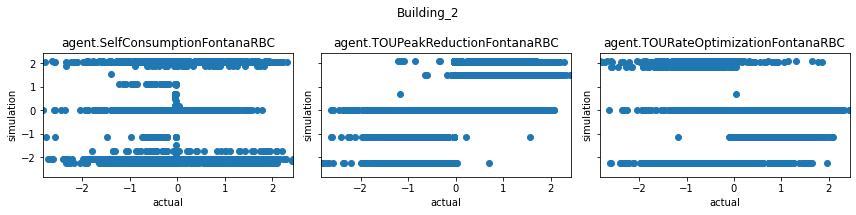

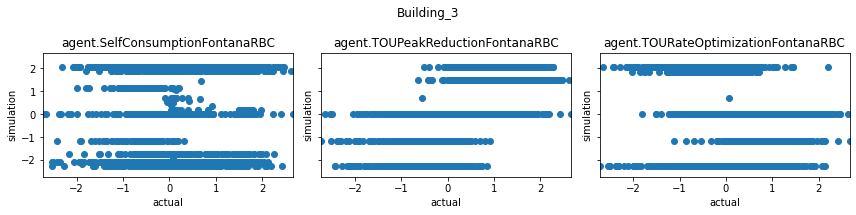

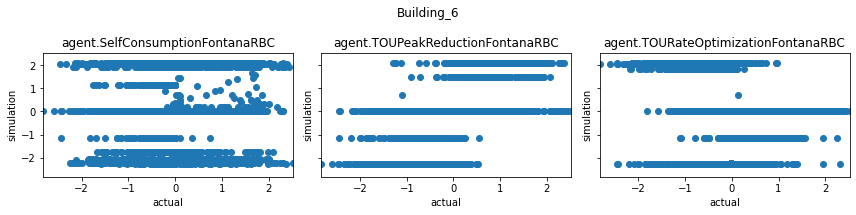

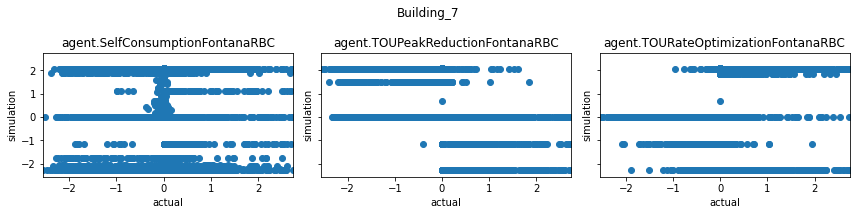

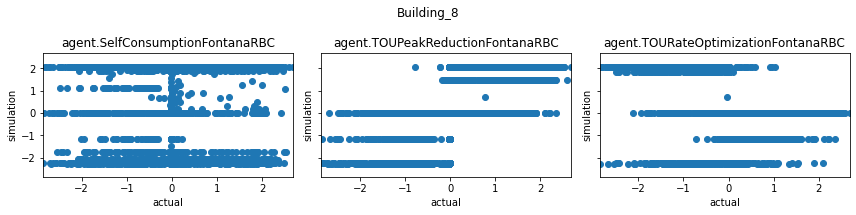

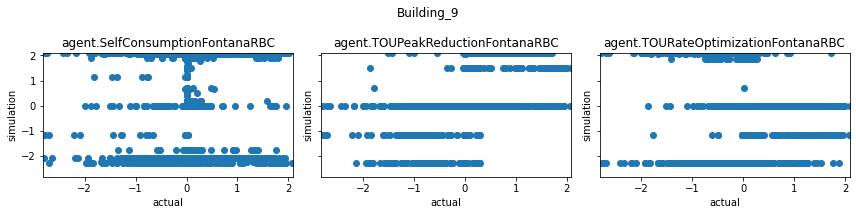

In [106]:
for building, building_data in rbc_validation_simulations.groupby('building_id'):
    row_count = 1
    column_count = len(rbc_validation_grid)
    fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count,3*row_count),sharex=True,sharey=True)

    for ax, (rbc_type, rbc_data) in zip(fig.axes, building_data.groupby('type')):
        x = rbc_data['actual_electrical_storage_electricity_consumption'] 
        y = rbc_data['simulation_electrical_storage_net_electricity_consumption']
        lim = (min(x.min(),y.min()), max(x.max(),y.max()))
        ax.scatter(x,y)
        ax.set_xlabel('actual')
        ax.set_ylabel('simulation')
        ax.set_title(rbc_type)
        ax.set_xlim(lim)
        ax.set_ylim(lim)
    
    fig.suptitle(building)
    plt.tight_layout()
    plt.show()

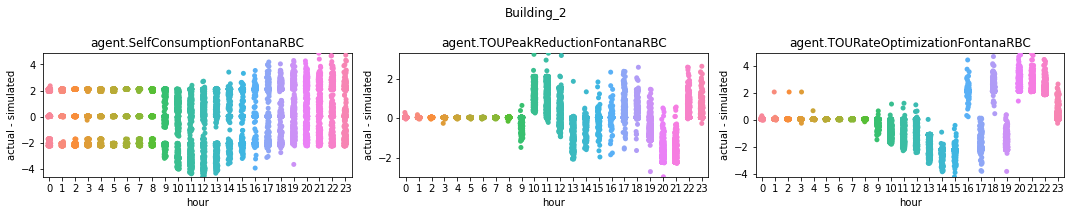

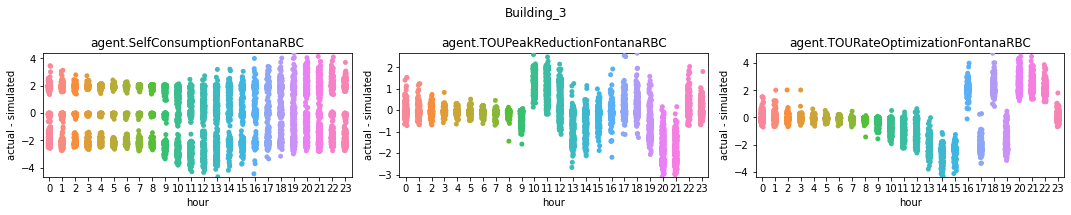

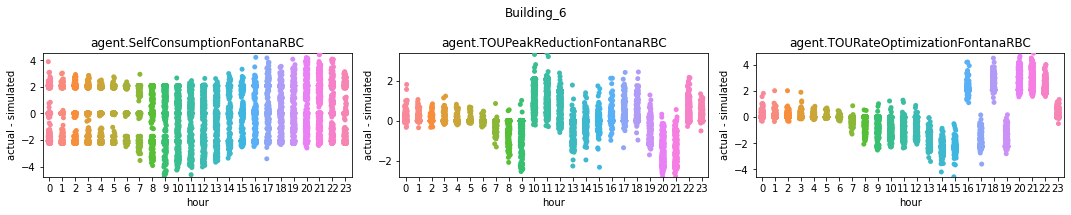

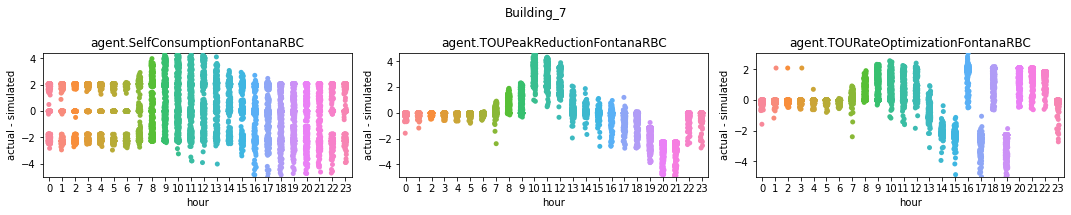

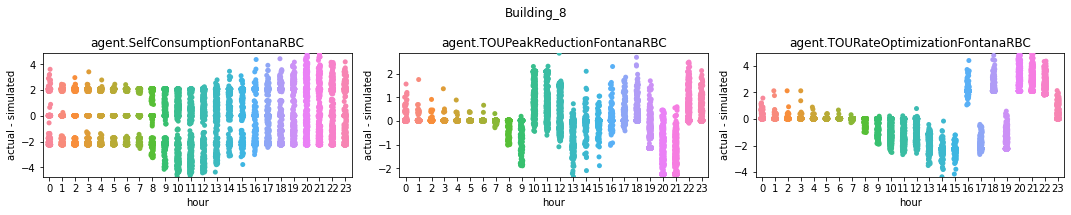

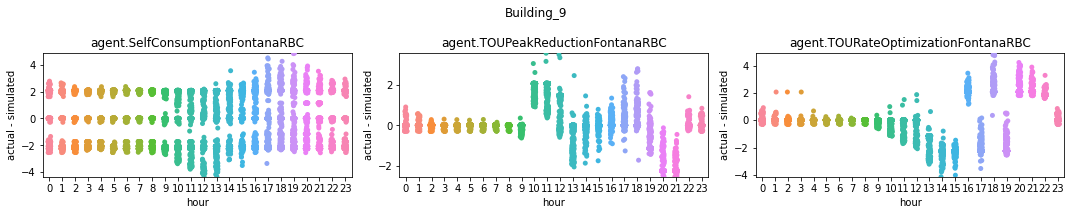

In [114]:
# hourly difference between actual and simulated
for building, building_data in rbc_validation_simulations.groupby('building_id'):
    row_count = 1
    column_count = len(rbc_validation_grid)
    fig, axs = plt.subplots(row_count, column_count, figsize=(5*column_count,3*row_count),sharey=False)

    for ax, (rbc_type, rbc_data) in zip(fig.axes, building_data.groupby('type')):
        sns.stripplot(x='hour',y='error',data=rbc_data,ax=ax)
        ax.set_xlabel('hour')
        ax.set_ylabel('actual - simulated')
        ax.set_title(rbc_type)
    
    fig.suptitle(building)
    plt.tight_layout()
    plt.show()

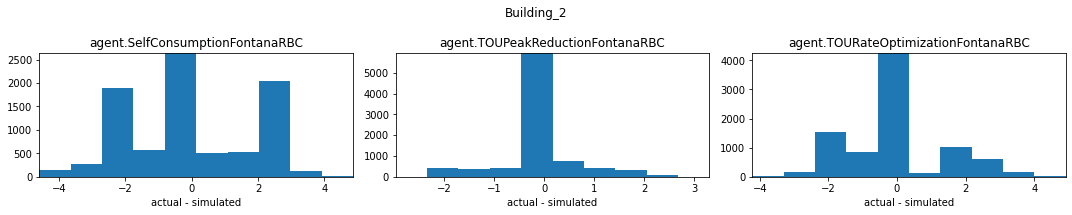

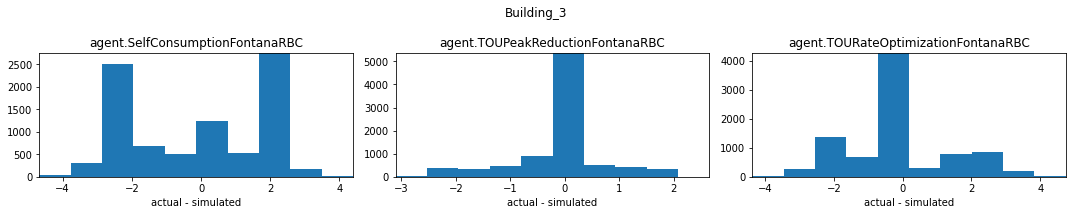

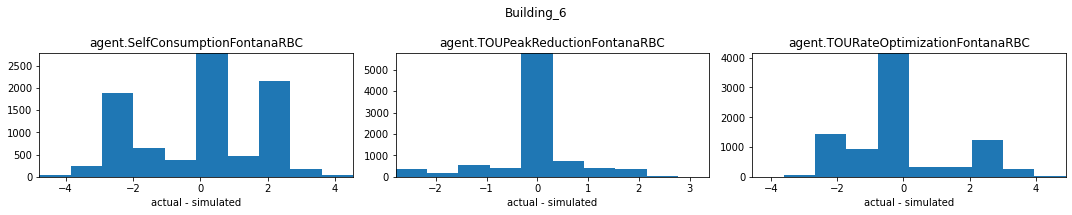

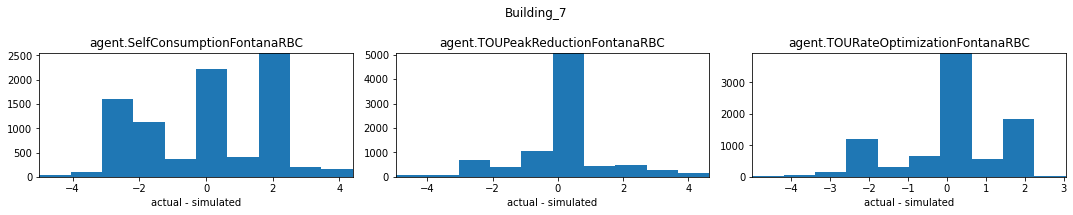

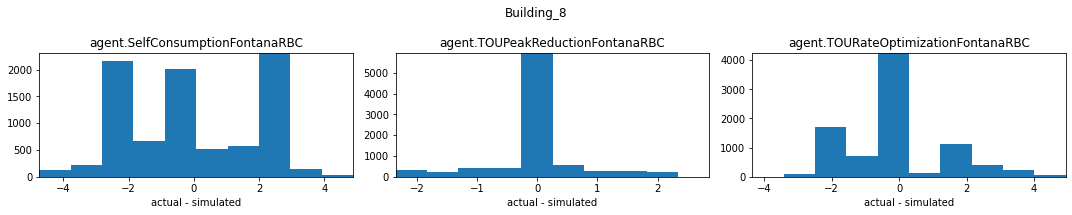

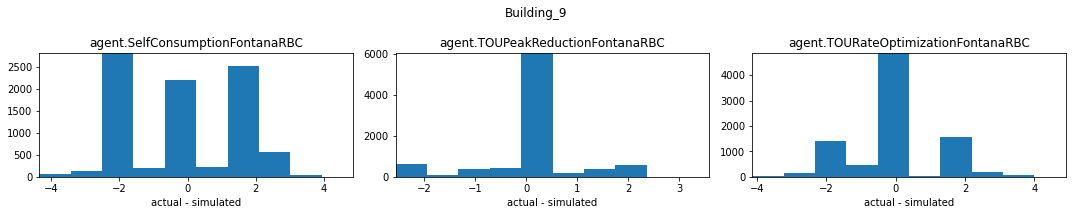

In [144]:
# hourly difference between actual and simulated
for building, building_data in rbc_validation_simulations.groupby('building_id'):
    row_count = 1
    column_count = len(rbc_validation_grid)
    fig, axs = plt.subplots(row_count, column_count, figsize=(5*column_count,3*row_count),sharey=False)

    for ax, (rbc_type, rbc_data) in zip(fig.axes, building_data.groupby('type')):
        x = rbc_data['error']
        ax.hist(x)
        ax.set_xlabel('actual - simulated')
        ax.set_title(rbc_type)
    
    fig.suptitle(building)
    plt.tight_layout()
    plt.show()

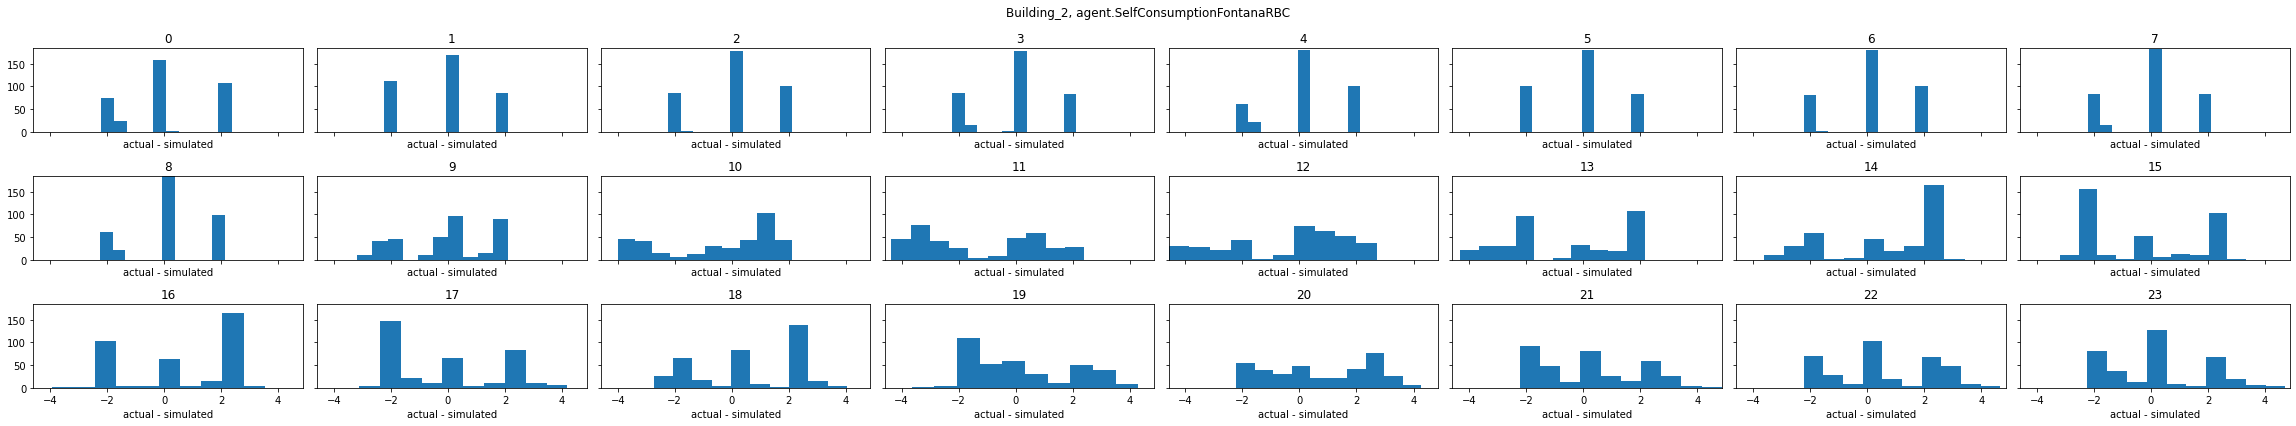

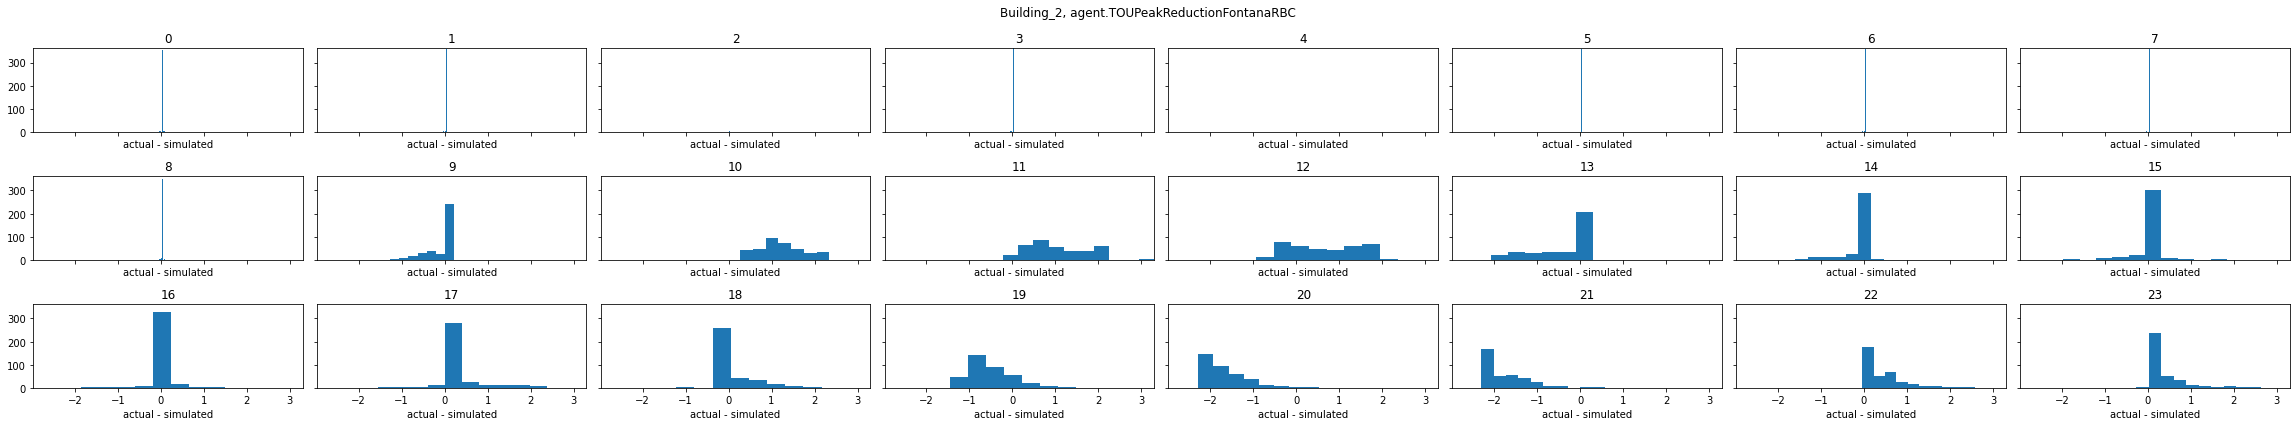

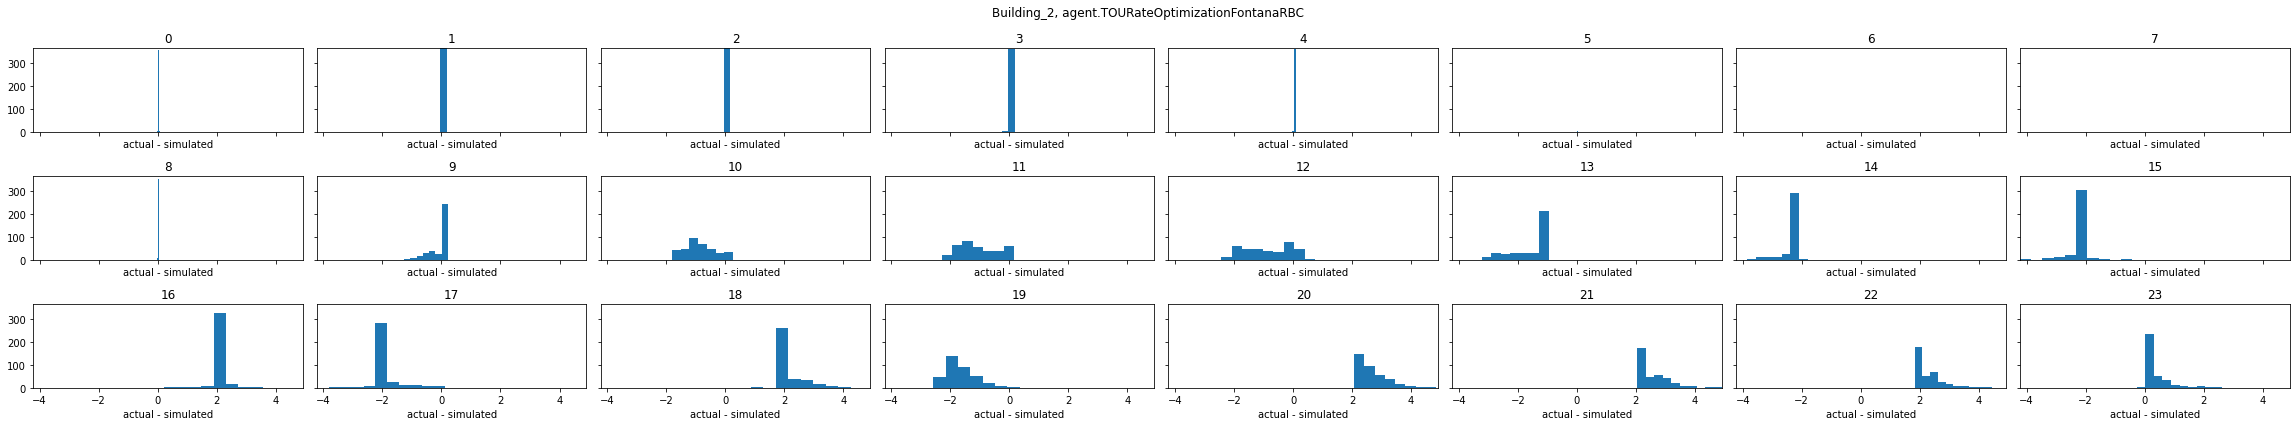

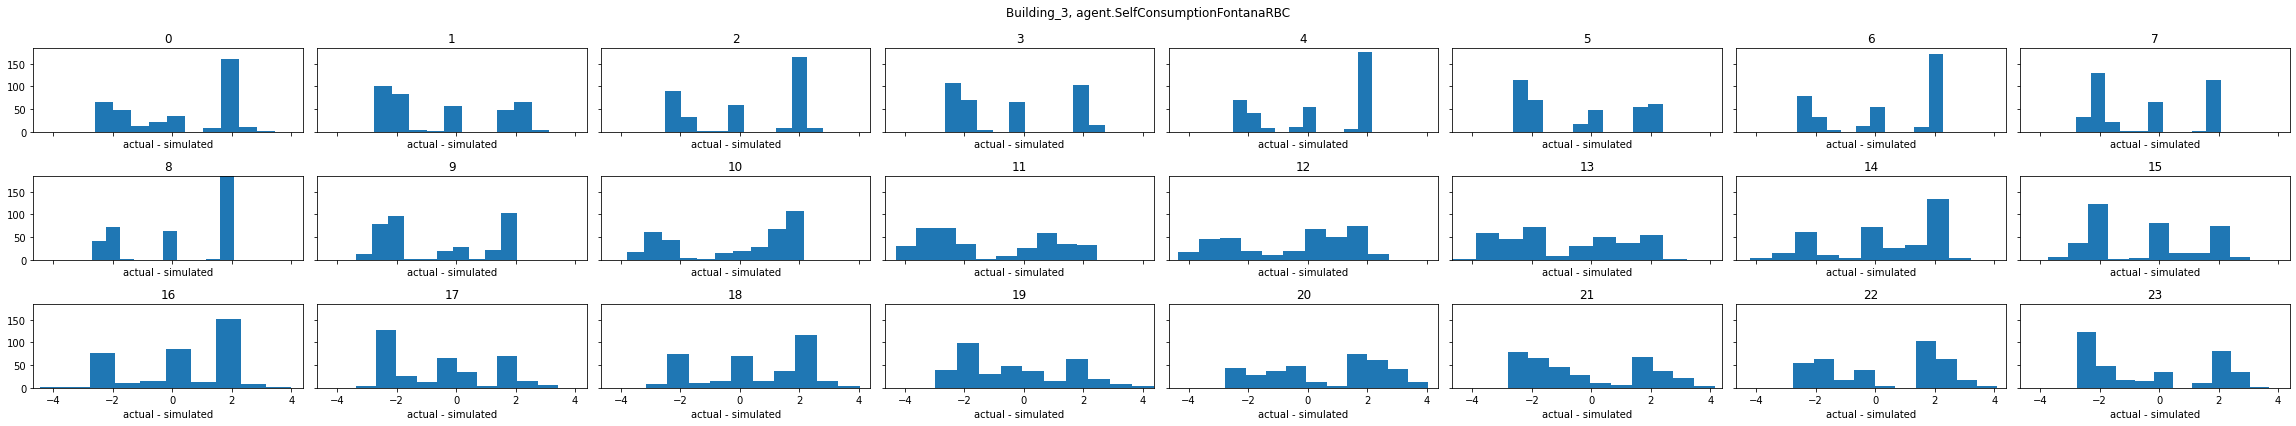

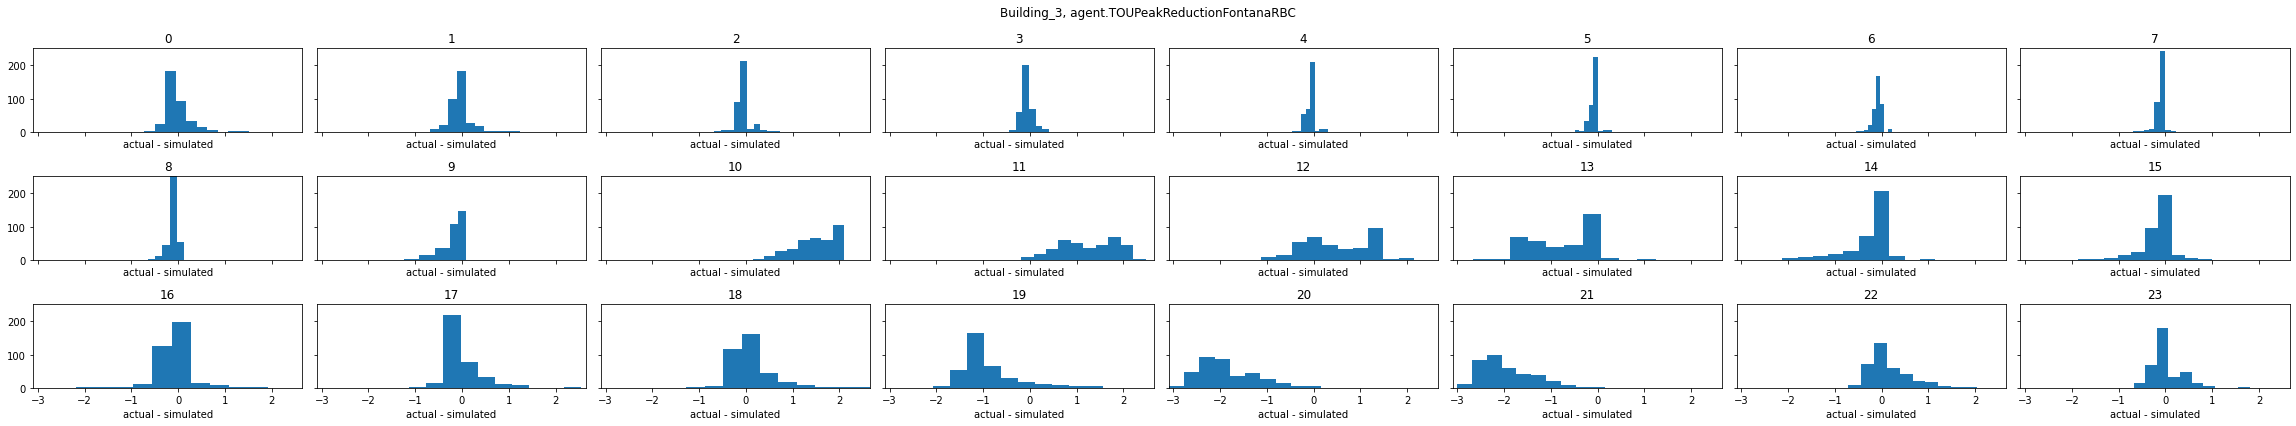

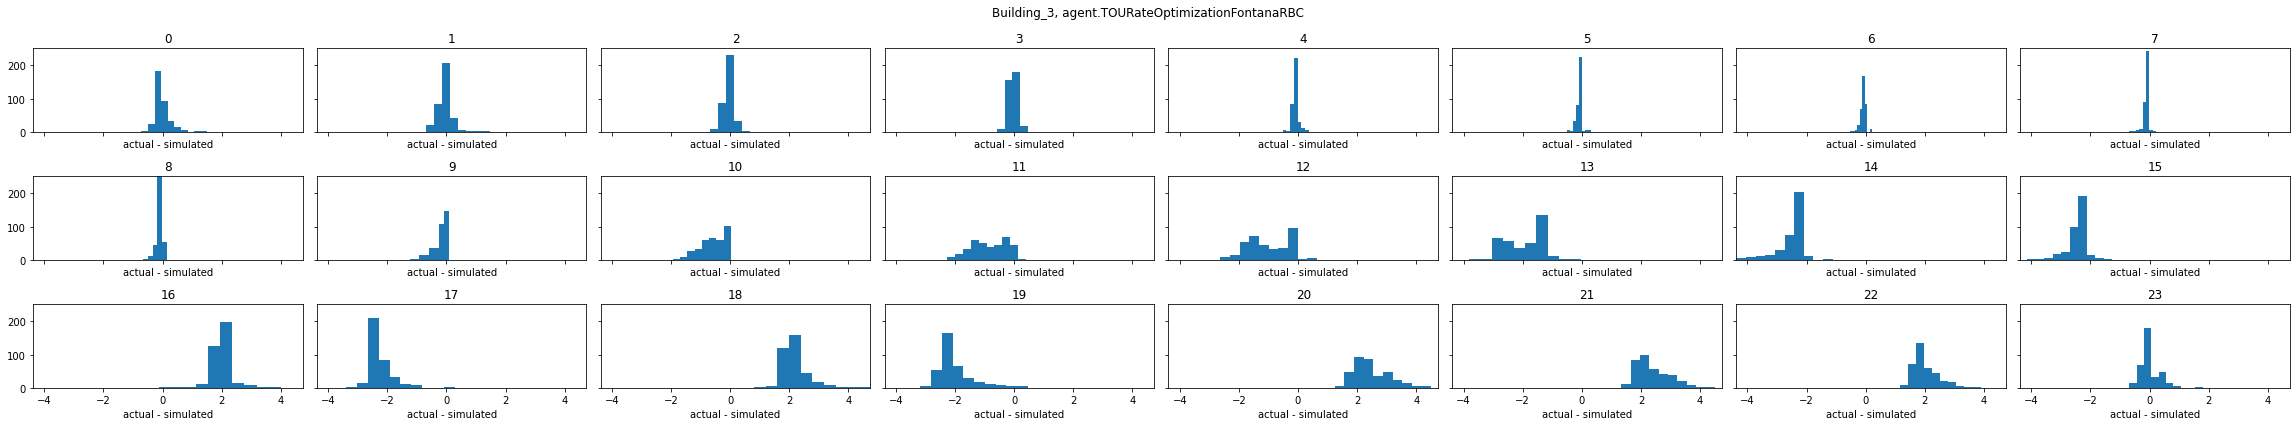

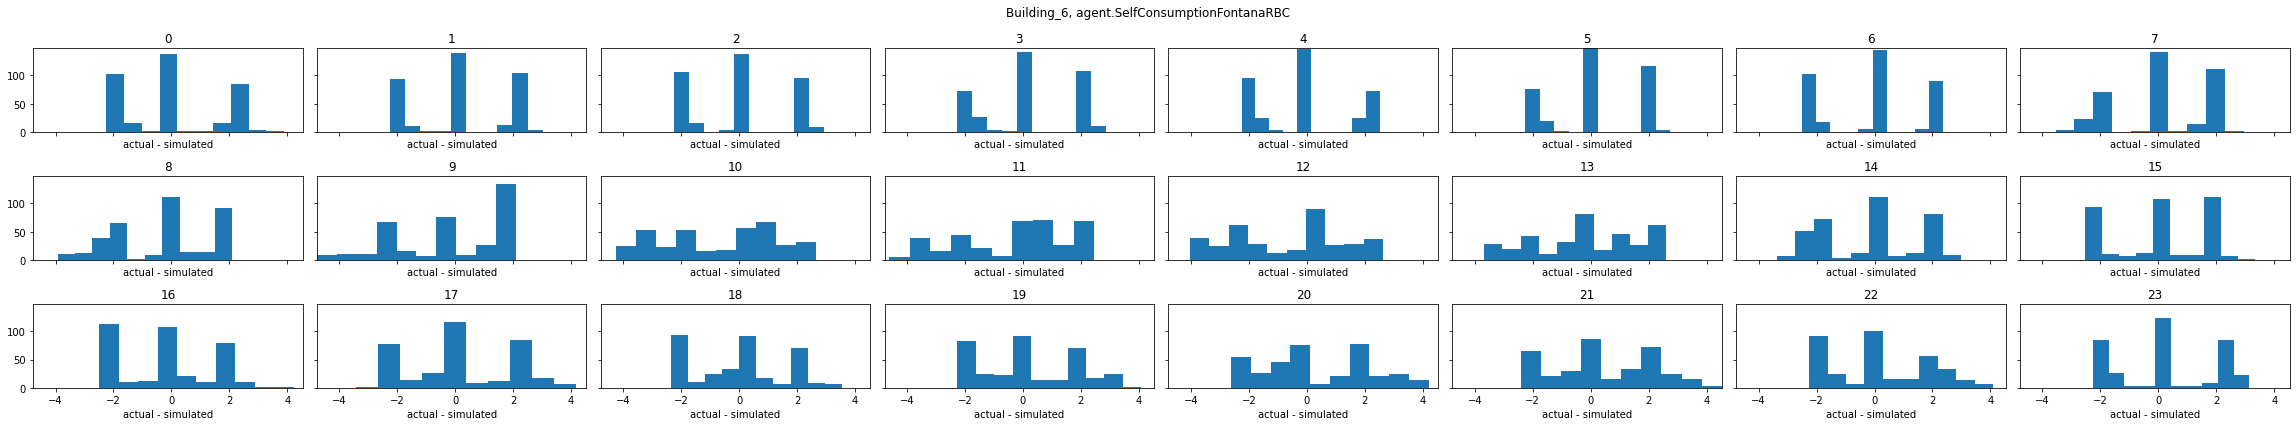

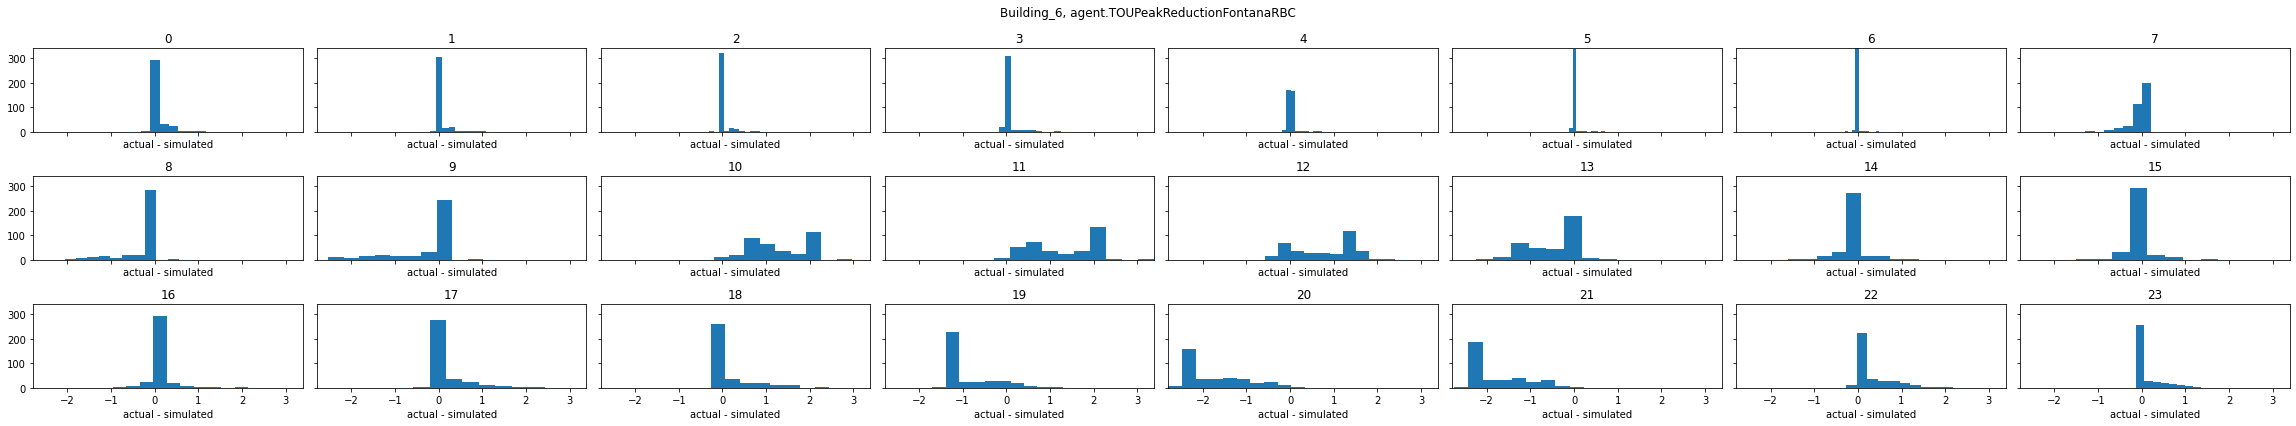

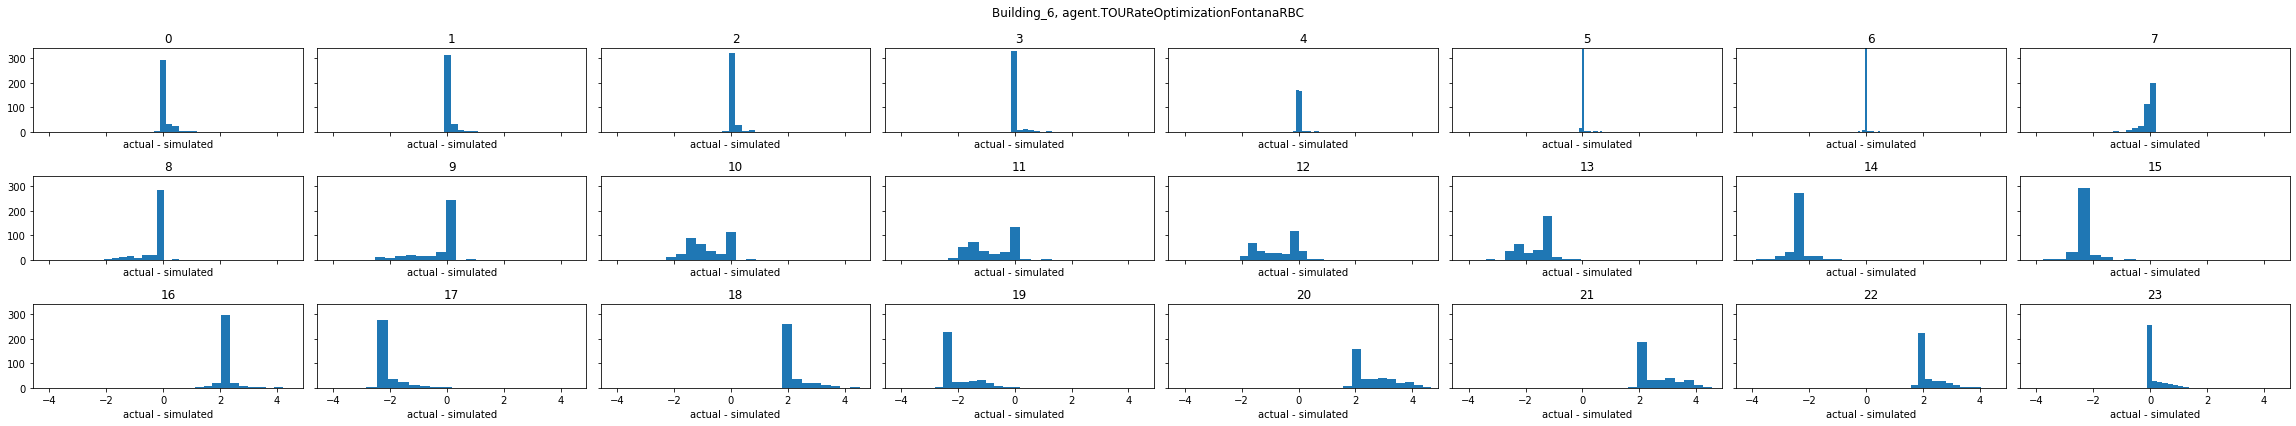

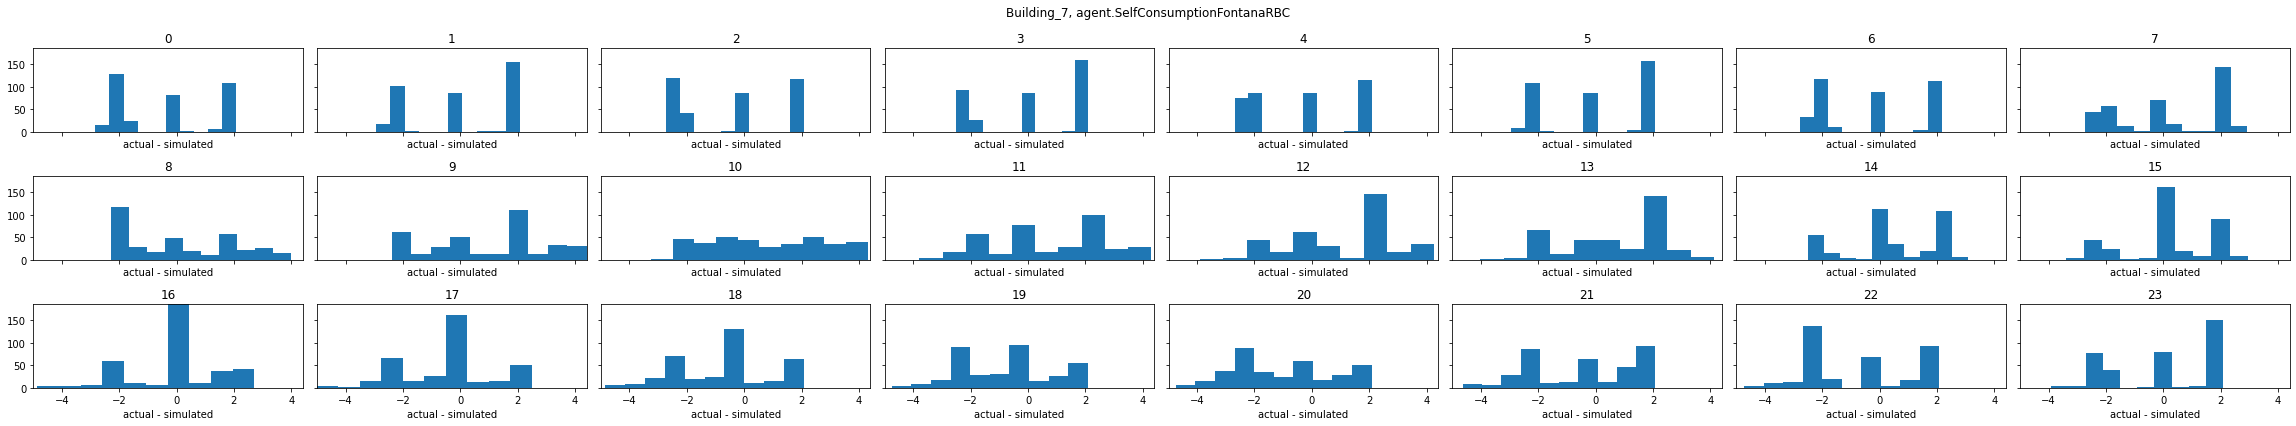

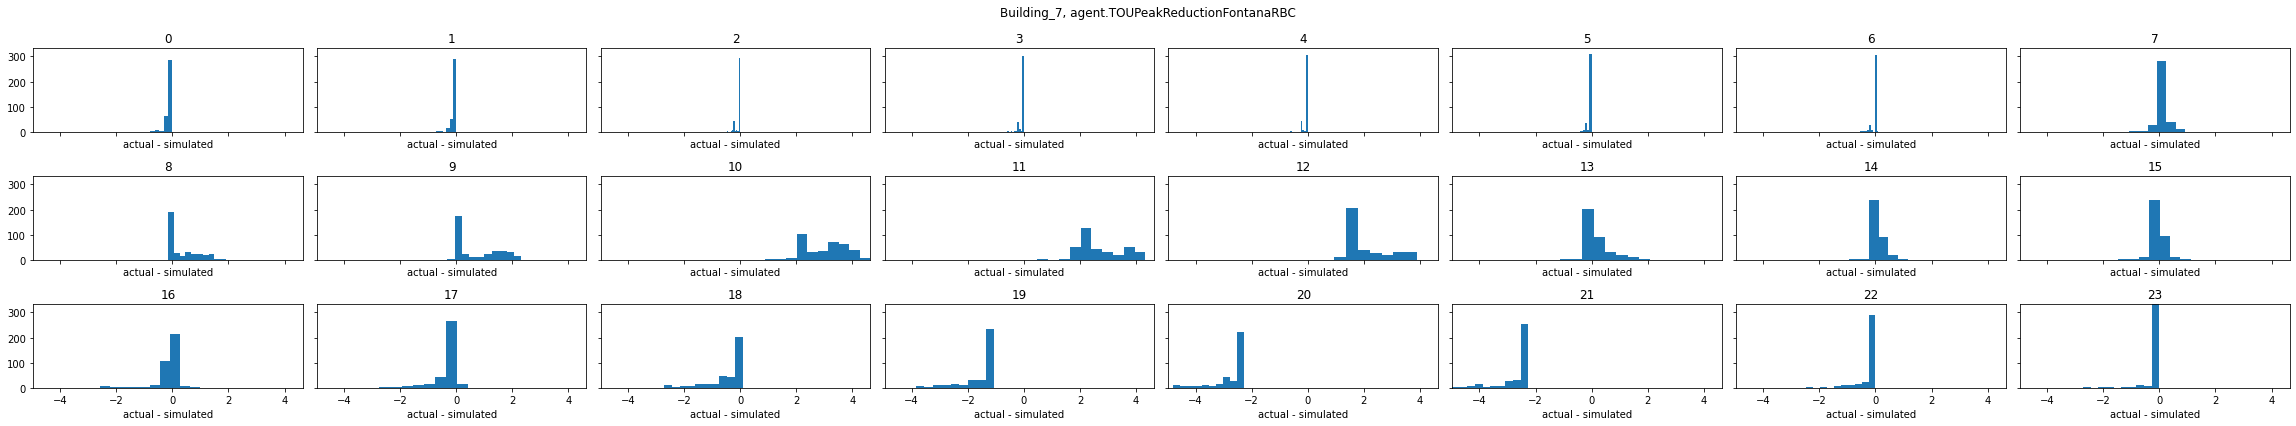

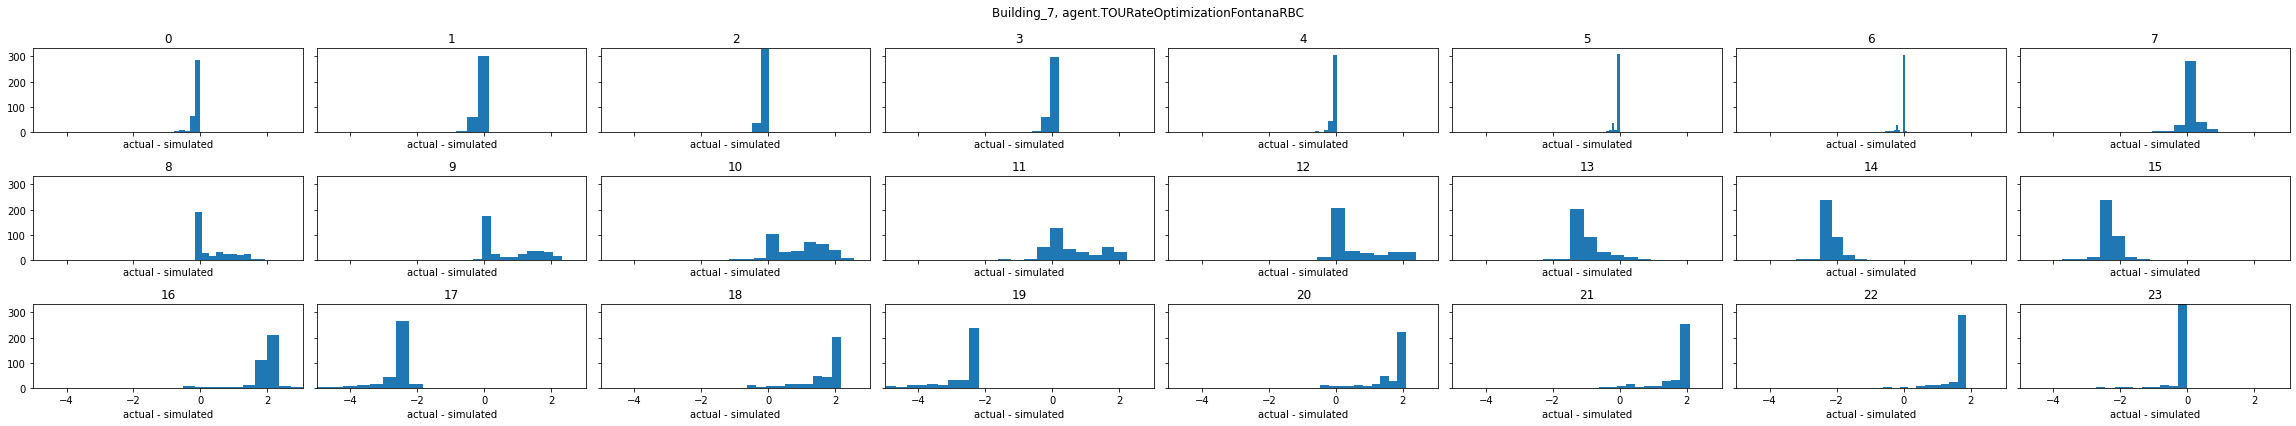

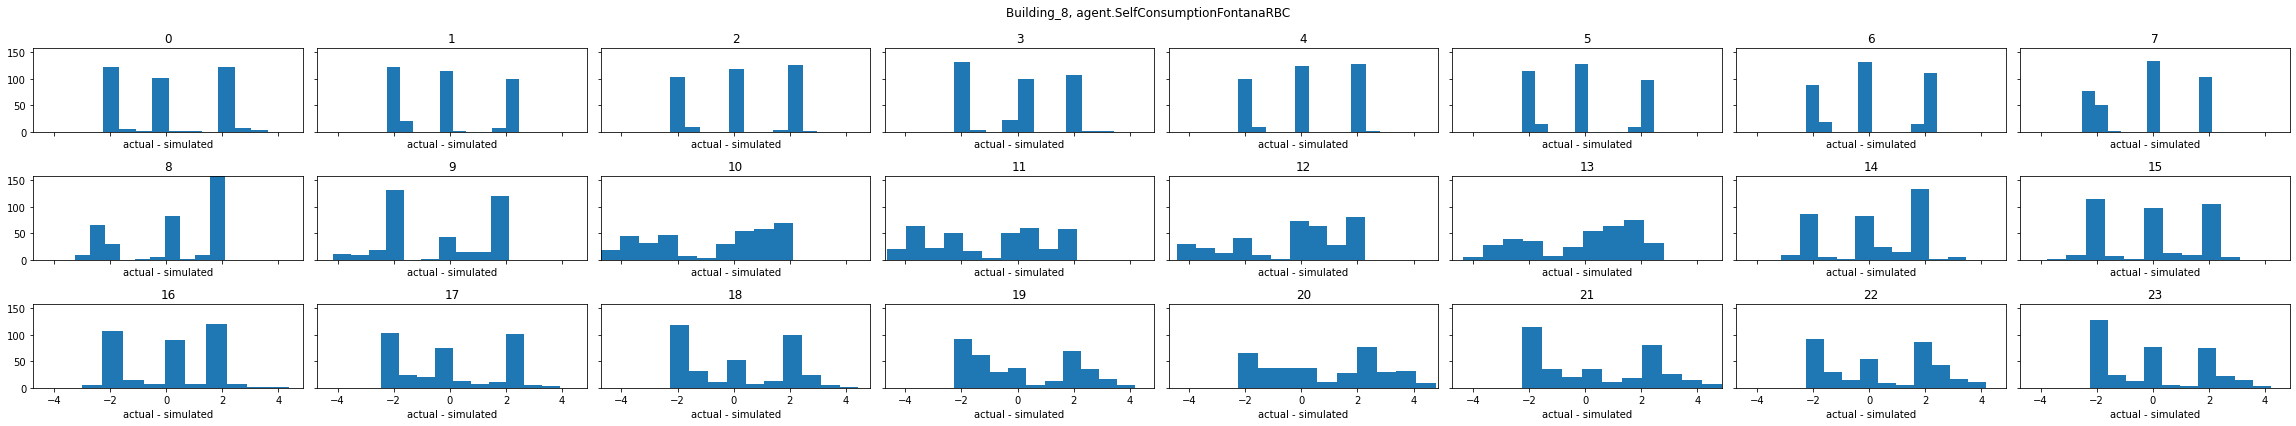

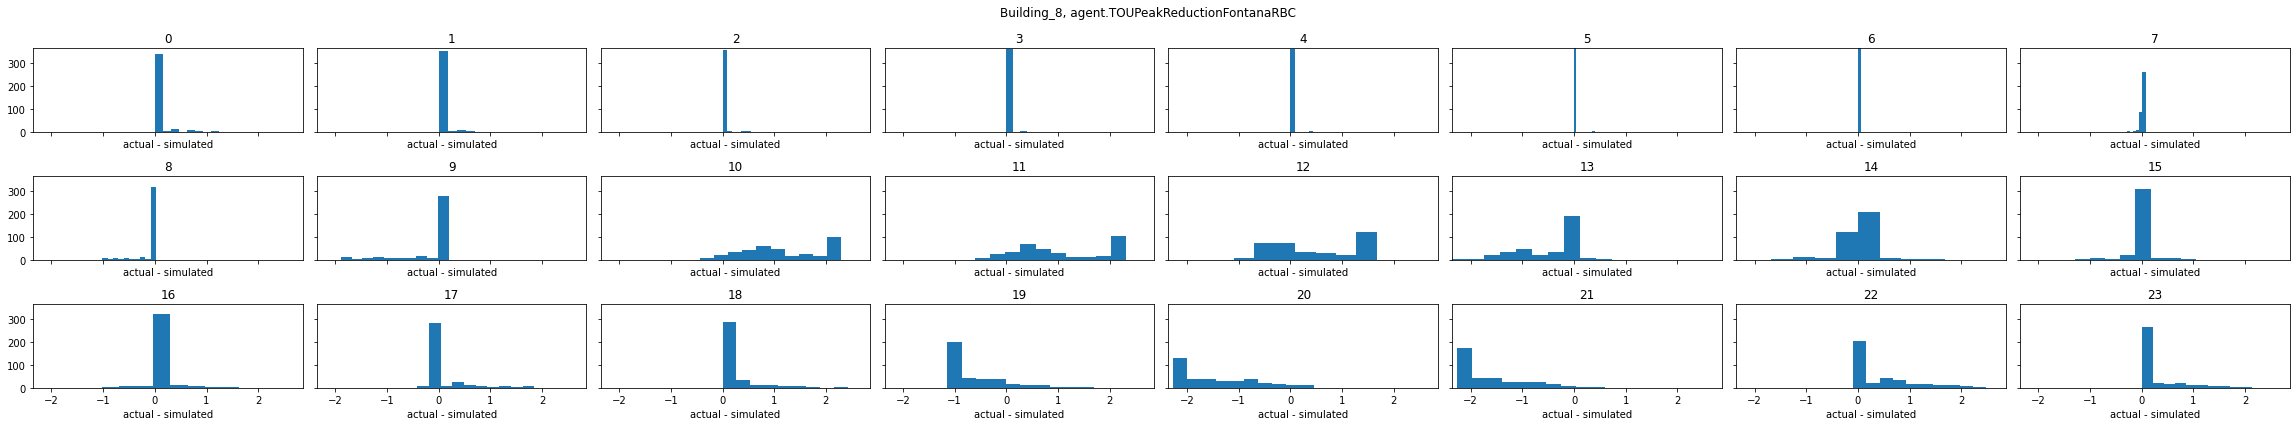

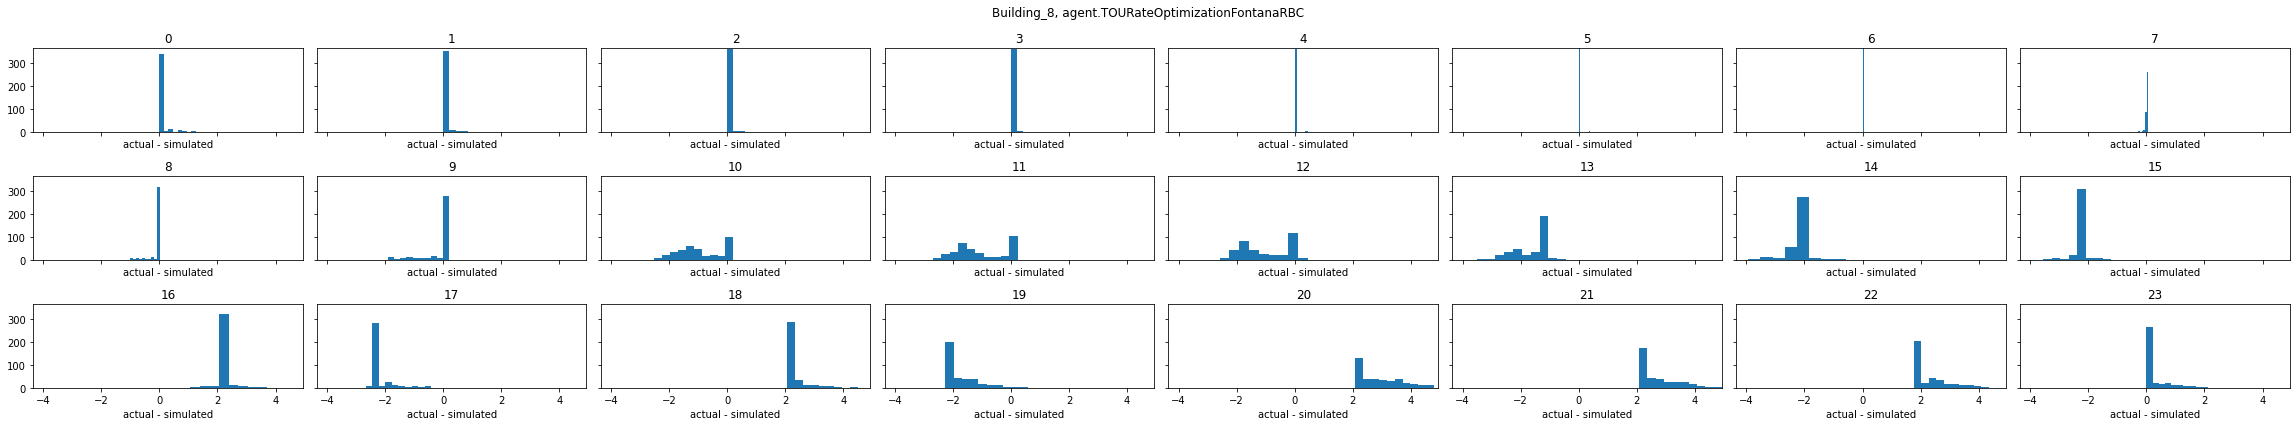

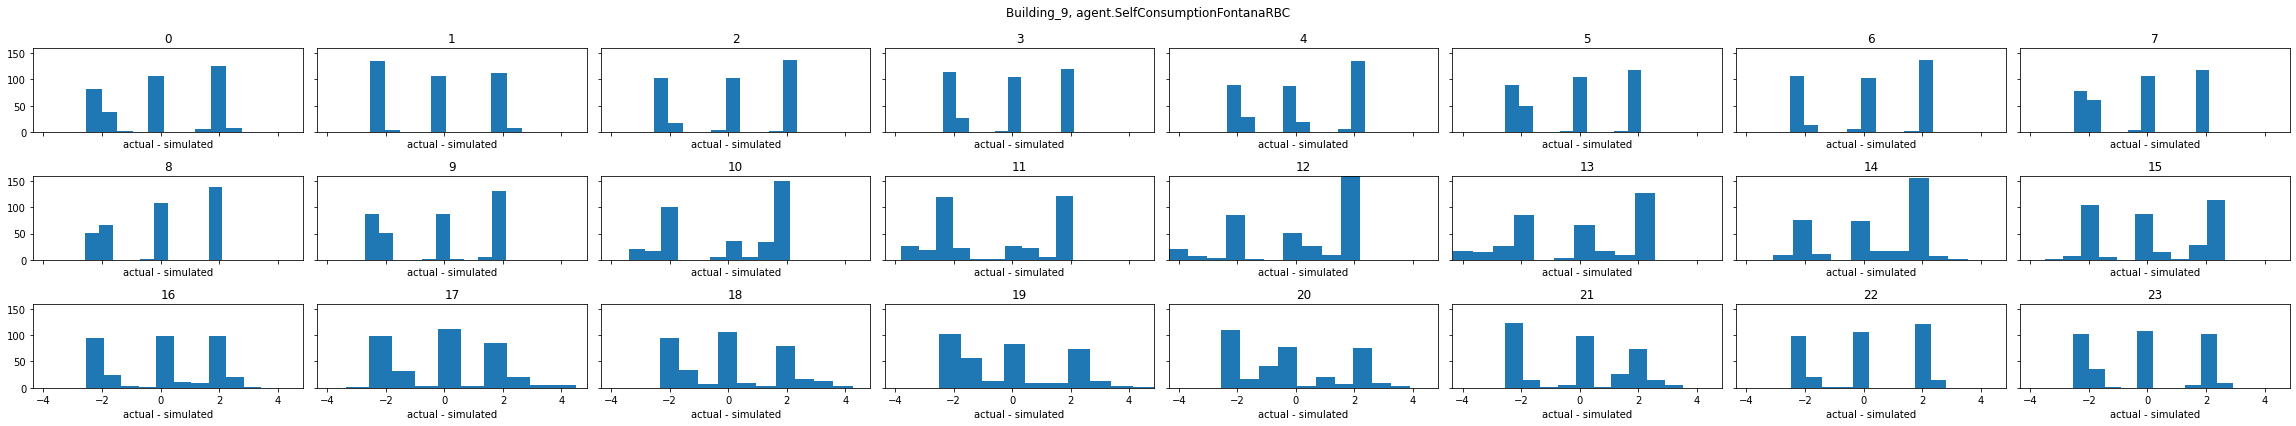

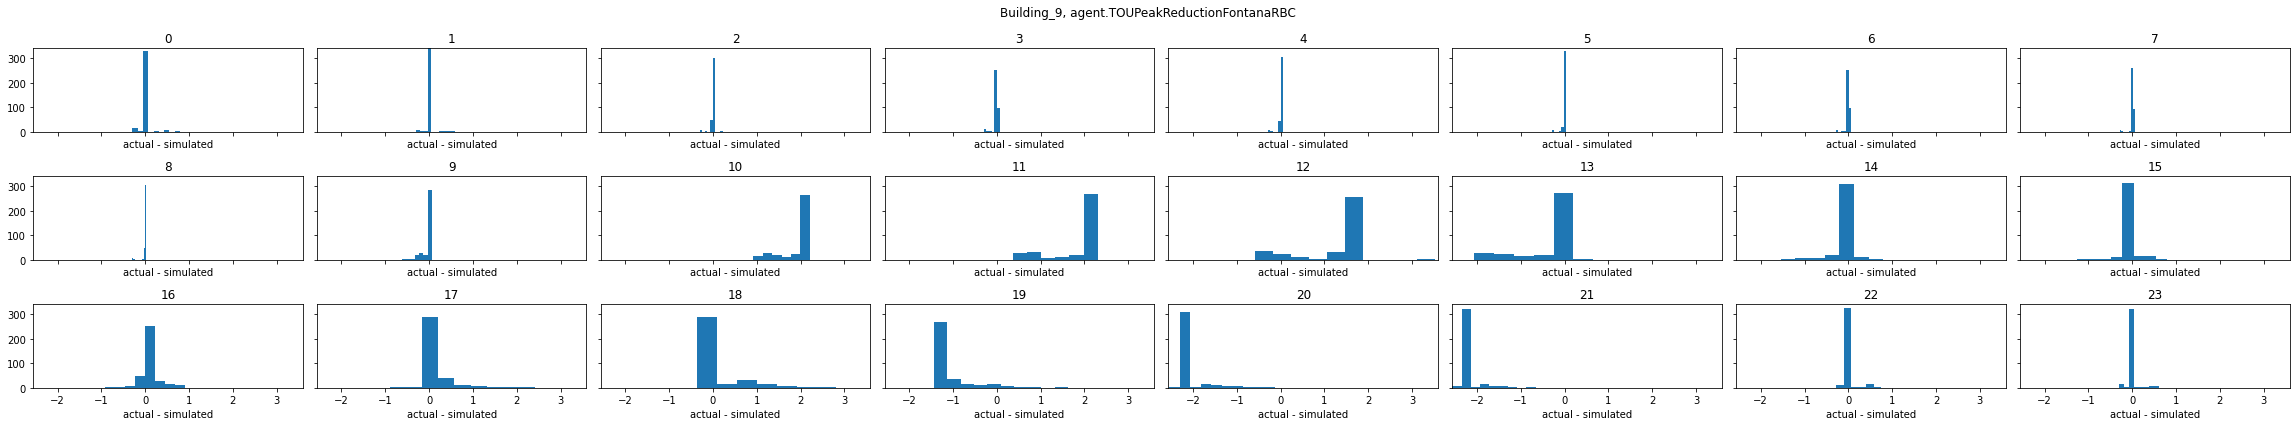

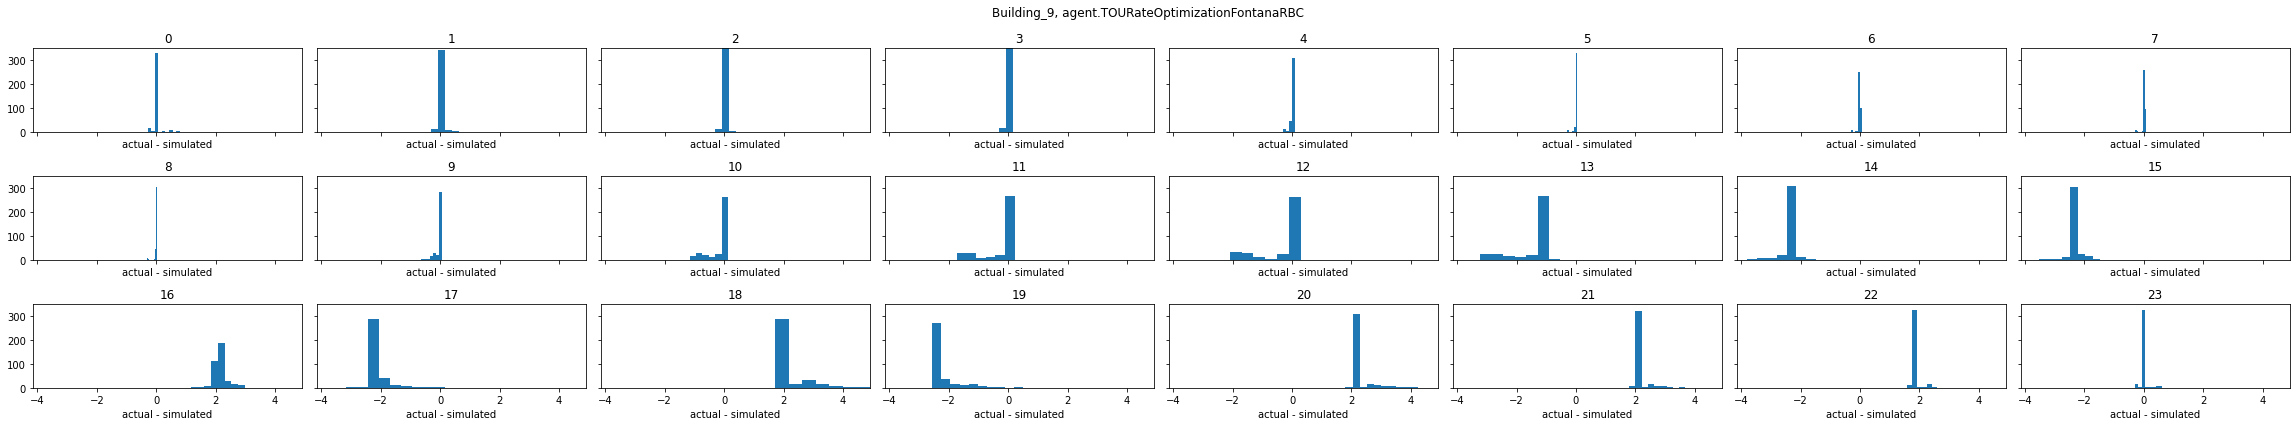

In [131]:
# how are the errors distributed hourly in a histogram?
column_count_limit = 8
hour_count = len(rbc_validation_simulations['hour'].unique())

for building, building_data in rbc_validation_simulations.groupby('building_id'):
    
    for rbc_type, rbc_data in building_data.groupby('type'):
        row_count = math.ceil(hour_count/column_count_limit)
        column_count = min(hour_count,column_count_limit)
        fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count,2*row_count),sharey=True,sharex=True)

        for ax, (hour, hour_data) in zip(fig.axes,rbc_data.groupby('hour')):
            x = hour_data['error']
            ax.hist(x,bins=10)
            ax.set_xlabel('actual - simulated')
            ax.set_title(hour)
    
        fig.suptitle(f'{building}, {rbc_type}')
        plt.tight_layout()
        plt.show()
    
    # assert False

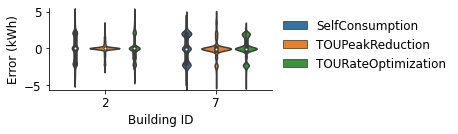

building_id                                 type     error            \
                                                          min       max   
0   Building_2      agent.SelfConsumptionFontanaRBC  0.001650  4.861753   
1   Building_2     agent.TOUPeakReductionFontanaRBC  0.000233  3.298010   
2   Building_2  agent.TOURateOptimizationFontanaRBC  0.000233  4.913941   
3   Building_3      agent.SelfConsumptionFontanaRBC  0.000167  4.672133   
4   Building_3     agent.TOUPeakReductionFontanaRBC  0.000017  3.101256   
5   Building_3  agent.TOURateOptimizationFontanaRBC  0.000017  4.739191   
6   Building_6      agent.SelfConsumptionFontanaRBC  0.000000  4.775136   
7   Building_6     agent.TOUPeakReductionFontanaRBC  0.000000  3.386477   
8   Building_6  agent.TOURateOptimizationFontanaRBC  0.000000  4.904248   
9   Building_7      agent.SelfConsumptionFontanaRBC  0.000000  4.994474   
10  Building_7     agent.TOUPeakReductionFontanaRBC  0.000000  4.964274   
11  Building_7  agent.TOURateOptimizationFontanaRBC  0.000000  4.998356   
12  Building_8      agent.SelfConsumptionFontanaRBC  0.000000  4.873047   
13  Building_8     agent.TOUPeakReductionFontanaRBC  0.000000  2.859277   
14  Building_8  agent.TOURateOptimizationFontanaRBC  0.000000  4.931451   
15  Building_9      agent.SelfConsumptionFontanaRBC  0.000000  4.856503   
16  Building_9     agent.TOUPeakReductionFontanaRBC  0.000000  3.592360   
17  Building_9  agent.TOURateOptimizationFontanaRBC  0.000000  4.902077   

                        
        mean       std  
0   1.438909  1.066928  
1   0.409936  0.631760  
2   1.061169  1.081623  
3   1.725916  0.868908  
4   0.506910  0.667566  
5   1.088785  1.060664  
6   1.389011  1.038571  
7   0.443248  0.685568  
8   1.061734  1.096048  
9   1.556937  1.018017  
10  0.754048  1.114251  
11  0.969708  1.002680  
12  1.591386  1.019862  
13  0.396447  0.647852  
14  1.090658  1.134444  
15  1.543338  0.951925  
16  0.484915  0.800188  
17  0.920427  1.054663

In [212]:
# error summary
building_ids = ['Building_2','Building_7']
rbc_validation_error_summary = rbc_validation_simulations.copy()
rbc_validation_error_summary['error'] = rbc_validation_error_summary['error'].abs()
rbc_validation_error_summary = rbc_validation_error_summary.groupby(['building_id','type'])[['error']].agg([min,max,'mean','std']).reset_index()
fig, ax = plt.subplots(1,1,figsize=(4,1.5))
plot_data = rbc_validation_simulations[rbc_validation_simulations['building_id'].isin(building_ids)].copy()
plot_data['type'] = plot_data['type'].str.replace('FontanaRBC','').str.split('.',expand=True)[1]
sns.violinplot(x='building_id',y='error',data=plot_data,hue='type')
ax.legend(
    bbox_to_anchor=(1.0,1),
    framealpha=0,
    ncol=1
)
ax.set_xlabel('Building ID')
ax.set_ylabel('Error (kWh)')
ax.set_xticklabels([l.get_text().split('_')[-1] for l in ax.get_xticklabels()])
ax.spines[['right','top']].set_visible(False)
filepath = os.path.join(KWARGS['figure_directory'],'rbc_validation.pdf')
plt.savefig(filepath,transparent=True,bbox_inches='tight')
plt.show()

display(rbc_validation_error_summary)

In [213]:
valid_rbc_simulation = rbc_validation_simulations[
    rbc_validation_simulations['type']=='agent.TOUPeakReductionFontanaRBC'
].copy()

# Deployment Strategy 1.0

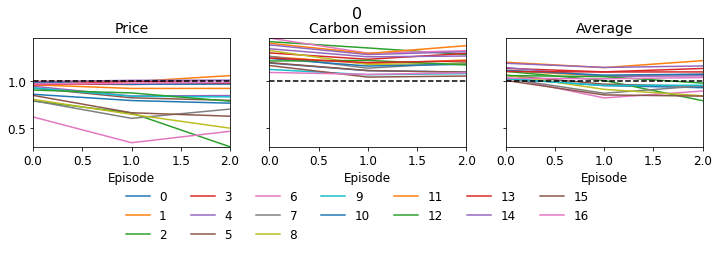

In [215]:
deployment_strategy_1_0_grid, deployment_strategy_1_0_summary, deployment_strategy_1_0_score_summary = get_brief_summary(
    'deployment_strategy_1_0',
    building_level=True
)

# score trajectory
plot_data = deployment_strategy_1_0_score_summary.copy()
fig_groupby_columns = ['group']
ax_groupby_columns = ['building_id']
plot_score_trajectory(plot_data,fig_groupby_columns,ax_groupby_columns,round_number=None)

# Deployment Strategy 3.0

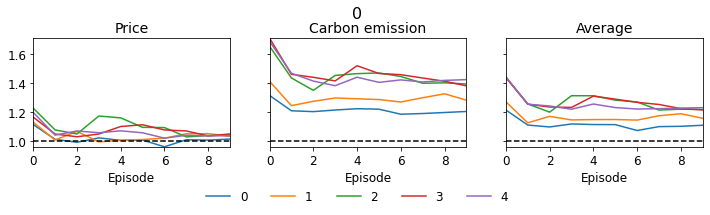

In [60]:
deployment_strategy_3_0_grid, deployment_strategy_3_0_summary, deployment_strategy_3_0_score_summary = get_brief_summary(
    'solar_reward',
    building_level=True
)

# score trajectory
plot_data = deployment_strategy_3_0_score_summary.copy()
fig_groupby_columns = ['group']
ax_groupby_columns = ['building_id']
plot_score_trajectory(plot_data,fig_groupby_columns,ax_groupby_columns,round_number=None)

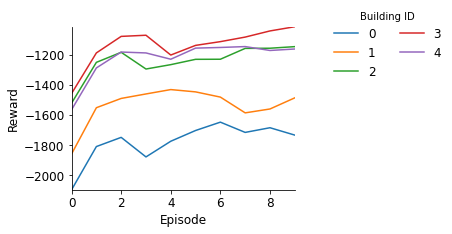

In [61]:
# reward trajectory
plot_data = deployment_strategy_3_0_score_summary.copy()
fig, ax = plt.subplots(1,1,figsize=(4,3))
linestyle = '-'

for i, (building_id, building_data) in enumerate(plot_data.groupby('building_id')):
    linestyle = '--' if i > 9 else linestyle
    building_data = building_data.sort_values('episode')
    x, y = building_data['episode'], building_data['reward_sum']
    ax.plot(x,y,label=building_id,linestyle=linestyle)

ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.spines[['right','top']].set_visible(False)
ax.legend(
    title='Building ID',
    bbox_to_anchor=(1.0,1.0), 
    bbox_transform=fig.transFigure,
    framealpha=0,
    ncol=2
)
plt.show()

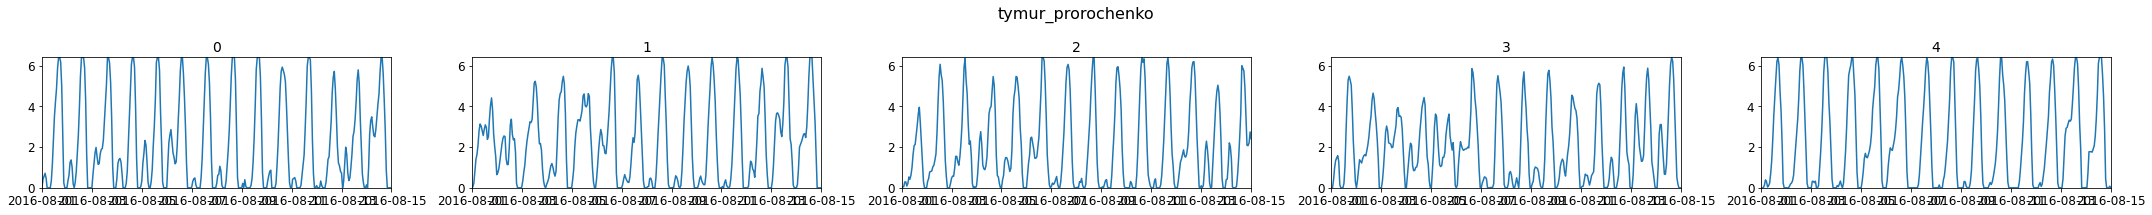

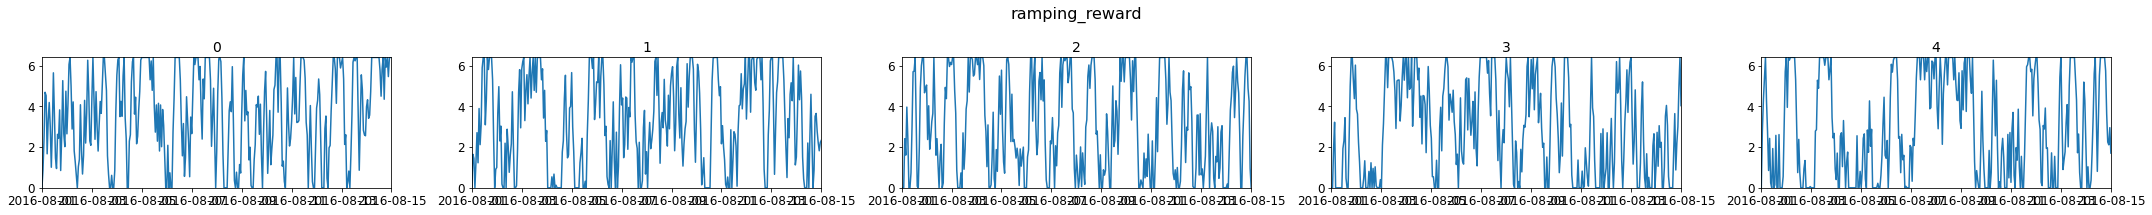

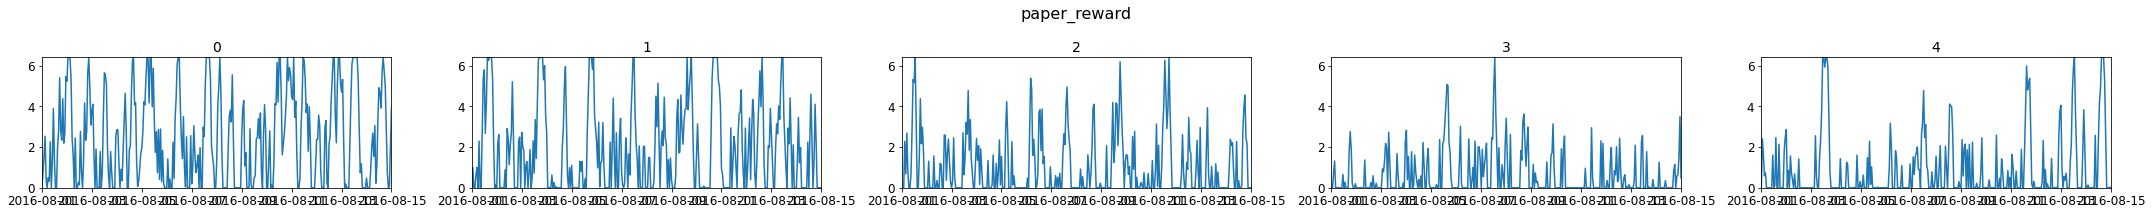

In [83]:
tymur_prorochenko = get_detailed_summary('tymur_prorochenko',building_level=True)
ramping_reward = get_detailed_summary('ramping_reward',building_level=True)
solar_reward = get_detailed_summary('solar_reward',building_level=True)
tymur_prorochenko = tymur_prorochenko[tymur_prorochenko['time_step']<=solar_reward['time_step'].max()].copy()
data_sets = {
    'tymur_prorochenko':[tymur_prorochenko],
    'ramping_reward':[ramping_reward],
    'paper_reward':[solar_reward]
}

for k, v in data_sets.items():
    v = v[0].copy()
    row_count = 1
    column_count = len(v['building_id'].unique())
    fig, axs = plt.subplots(row_count,column_count,figsize=(6*column_count,3*row_count))

    for ax, (building_id, building_data) in zip(fig.axes, v.groupby(['building_id'])):
        building_data = building_data[
            (building_data['timestamp']>='2016-08-01')
            &(building_data['timestamp']<='2016-08-15')
            &(building_data['episode']==building_data['episode'].max())
        ].sort_values('timestamp').copy()
        x = building_data['timestamp']
        y = building_data['electrical_storage_soc']
        ax.plot(x, y, label=building_id)
        ax.set_title(building_id)
        # ax.legend()
    
    fig.suptitle(k)
    plt.tight_layout()
    plt.show()

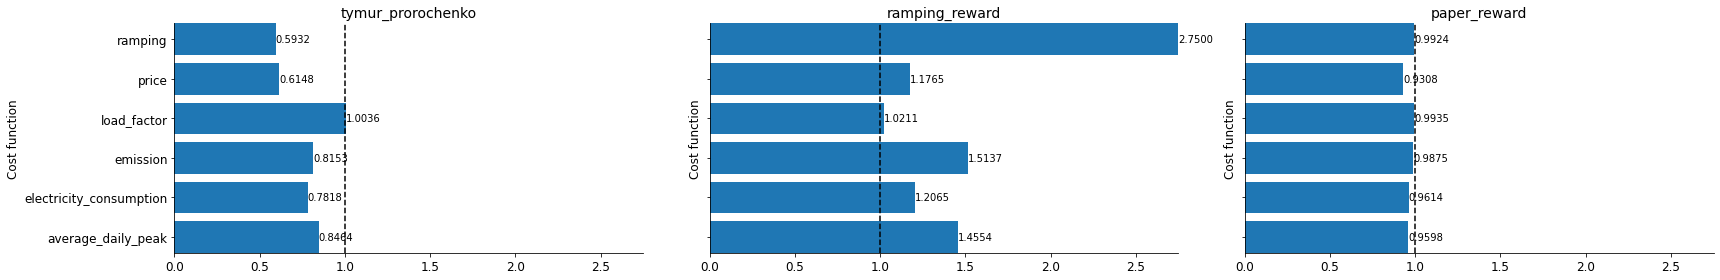

In [67]:
tymur_prorochenko = get_detailed_summary('tymur_prorochenko',building_level=False)
ramping_reward = get_detailed_summary('ramping_reward',building_level=False)
solar_reward = get_detailed_summary('deployment_strategy_1_0',building_level=False)
tymur_prorochenko = tymur_prorochenko[tymur_prorochenko['time_step']<=solar_reward['time_step'].max()].copy()
suffixes = ['', '_without_storage']
data_sets = {
    'tymur_prorochenko':[tymur_prorochenko],
    'ramping_reward':[ramping_reward],
    'paper_reward':[solar_reward]
}

for k, v in data_sets.items():
    v = v[0].copy()
    group_list = []

    for suffix in suffixes:
        for episode, group in v.groupby(['episode']):
            group = group.copy()
            column = 'net_electricity_consumption' + suffix
            group['average_daily_peak'] = CostFunction.average_daily_peak(group[column])
            group['load_factor'] = CostFunction.load_factor(group[column])
            group['ramping'] = CostFunction.ramping(group[column])
            group['emission'] = CostFunction.carbon_emissions(group['net_electricity_consumption_emission'+suffix])
            group['price'] = CostFunction.price(group['net_electricity_consumption_price'+suffix])
            group['electricity_consumption'] = CostFunction.net_electricity_consumption(group[column])
            group['storage'] = 'without_storage' if 'without' in suffix else 'with_storage'
            group_list.append(group)

    plot_data = pd.concat(group_list,ignore_index=True)
    del group_list
    plot_data = plot_data.melt(
        id_vars=['episode','time_step','storage'],
        value_vars=['average_daily_peak','load_factor','ramping','emission','price','electricity_consumption'],
        var_name='cost_function'
    )
    plot_data = plot_data.pivot_table(index=['episode','time_step','cost_function'],columns='storage',values='value')
    plot_data = plot_data.reset_index()
    plot_data['score'] = plot_data['with_storage']/plot_data['without_storage']
    data_sets[k].append(plot_data)

# final score
row_count = 1
column_count = len(data_sets)
fig, axs = plt.subplots(row_count,column_count,figsize=(column_count*8,row_count*4),sharex=True,sharey=True)

for ax, (k, v) in zip(fig.axes, data_sets.items()):
    v = v[1].copy()

    final_data = v[
        (v['episode']==v['episode'].max())
        &(v['time_step']==v['time_step'].max())
    ].copy()
    y = final_data['score']
    x = final_data['cost_function']
    rects = ax.barh(x,y)
    ax.bar_label(rects,fmt='%.4f',label_type='edge')
    ax.axvline(1.0,color='black',linestyle='--')
    ax.set_ylabel('Cost function')
    ax.set_yticks(x.tolist())
    ax.set_yticklabels(x.tolist())
    ax.spines[['right','top']].set_visible(False)
    ax.set_title(k)

plt.tight_layout()
plt.show()

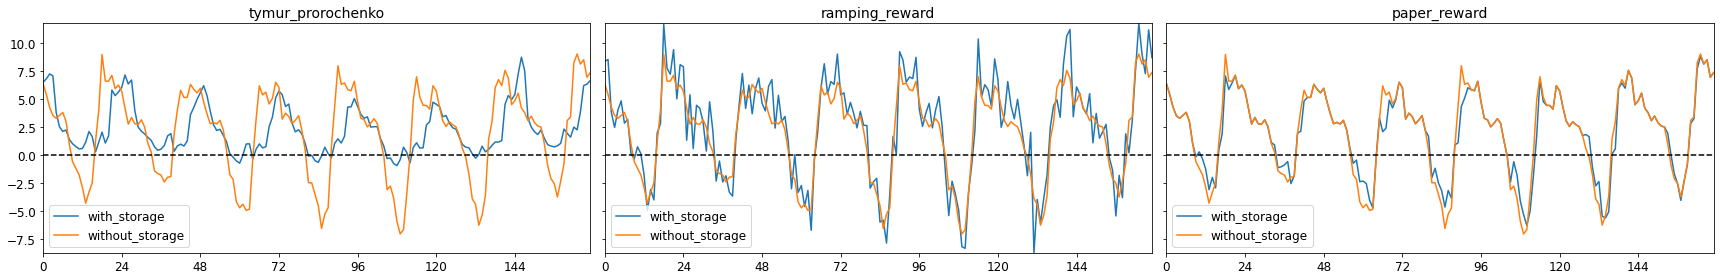

In [63]:
# average weekly profile
row_count = 1
column_count = len(data_sets)
fig, axs = plt.subplots(row_count,column_count,figsize=(column_count*8,row_count*4),sharex=True,sharey=True)

for ax, (k, v) in zip(fig.axes, data_sets.items()):
    v = v[0].copy()
    v = v[
        (v['episode']==v['episode'].max())
        &(v['timestamp'].dt.month.isin([9]))
    ].copy()
    v['hour'] = v['timestamp'].dt.hour
    v['day_of_week'] = v['timestamp'].dt.weekday
    v = v.groupby(['day_of_week','hour'])[['net_electricity_consumption','net_electricity_consumption_without_storage']].mean()
    v = v.reset_index()
    x, y1, y2 = v.reset_index().index, v['net_electricity_consumption'], v['net_electricity_consumption_without_storage']
    ax.plot(x, y1, label='with_storage')
    ax.plot(x, y2, label='without_storage')
    ax.axhline(0.0,color='black',linestyle='--')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.set_title(k)
    ax.legend()

plt.tight_layout()
plt.show()

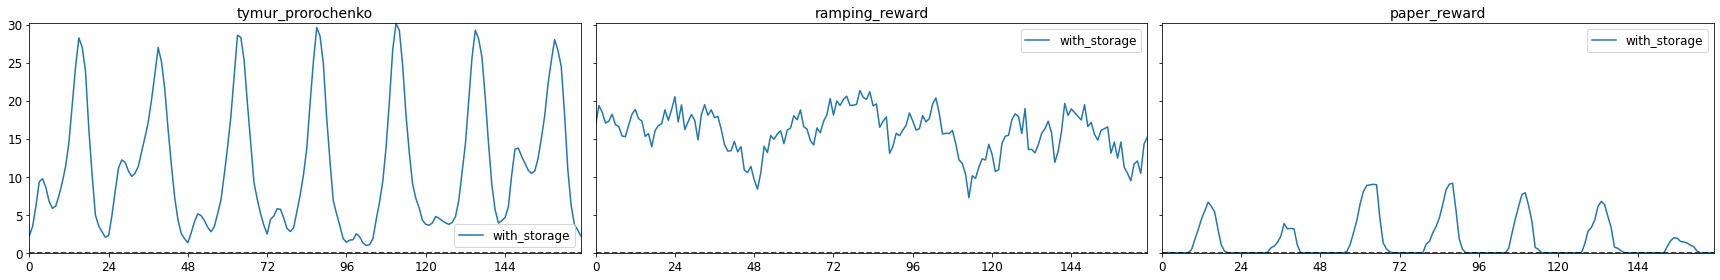

In [69]:
# average weekly profile
row_count = 1
column_count = len(data_sets)
fig, axs = plt.subplots(row_count,column_count,figsize=(column_count*8,row_count*4),sharex=True,sharey=True)

for ax, (k, v) in zip(fig.axes, data_sets.items()):
    v = v[0].copy()
    v = v[
        (v['episode']==v['episode'].max())
        &(v['timestamp'].dt.month.isin([9]))
    ].copy()
    v['hour'] = v['timestamp'].dt.hour
    v['day_of_week'] = v['timestamp'].dt.weekday
    v = v.groupby(['day_of_week','hour'])[['electrical_storage_soc']].mean()
    v = v.reset_index()
    # x, y1, y2 = v.index, v['net_electricity_consumption'], v['net_electricity_consumption_without_storage']
    x, y1 = v.index, v['electrical_storage_soc']
    ax.plot(x, y1, label='with_storage')
    # ax.plot(x, y2, label='without_storage')
    ax.axhline(0.0,color='black',linestyle='--')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.set_title(k)
    ax.legend()

plt.tight_layout()
plt.show()

In [119]:
# plot_data[plot_data['cost_function']=='price'].groupby(['building_id','cost_function'])[['score']].max()

In [120]:
# data = plot_data[
#     (plot_data['building_id']==2)
#     &(plot_data['episode']==0)
#     &(plot_data['cost_function']=='average_daily_peak')
# ].copy()
# data

In [121]:
# data = deployment_strategy_3_0_building_detailed_summary.copy()
# data = data[
#     (data['building_id']==2)
#     &(data['episode']==0)
# ].copy()
# data.set_index('time_step').iloc[0:24][['net_electricity_consumption','net_electricity_consumption_without_storage']].plot(figsize=(12,4))

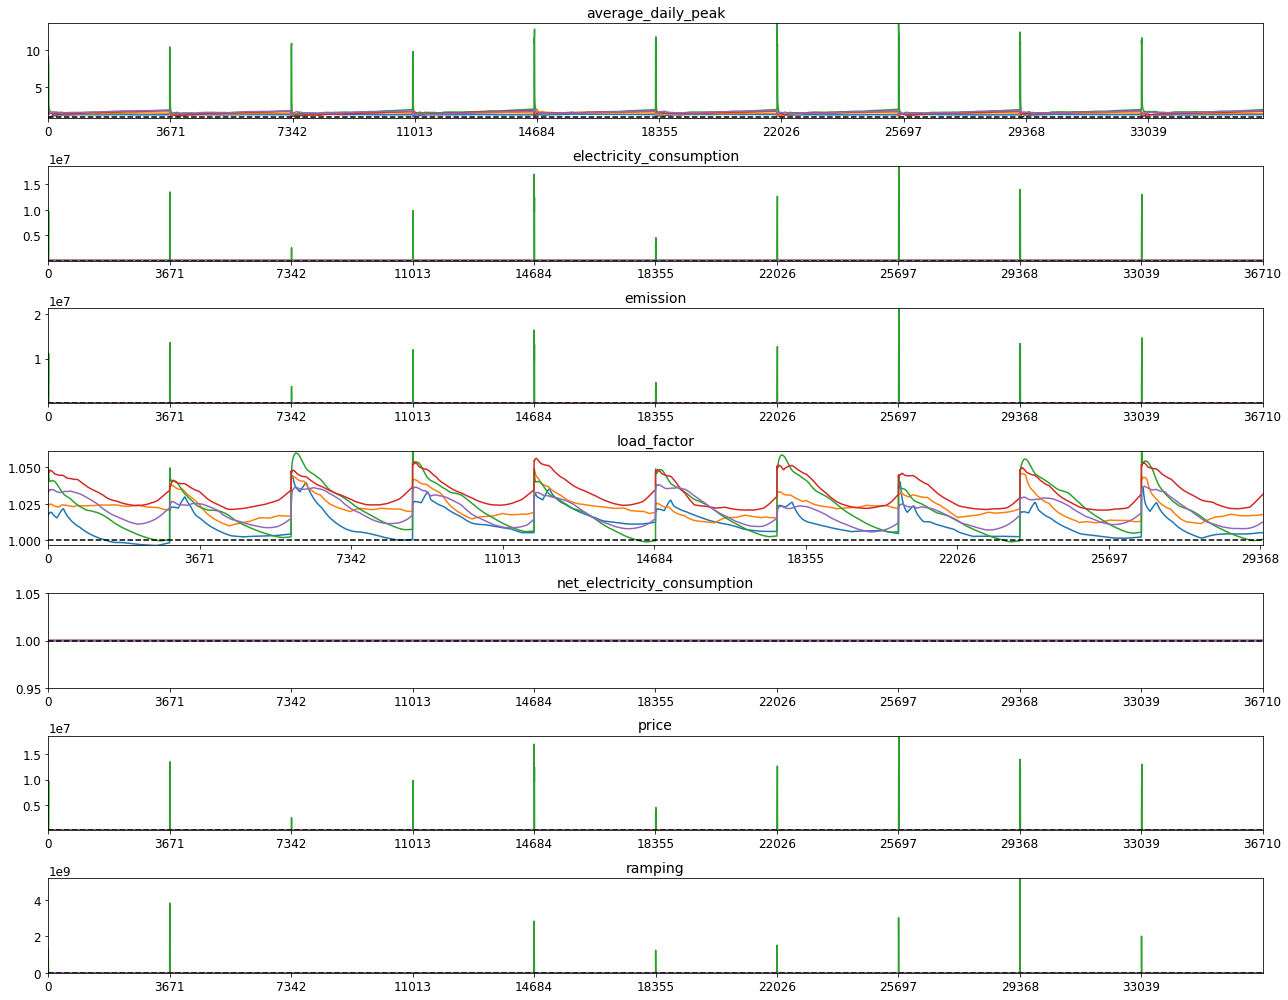

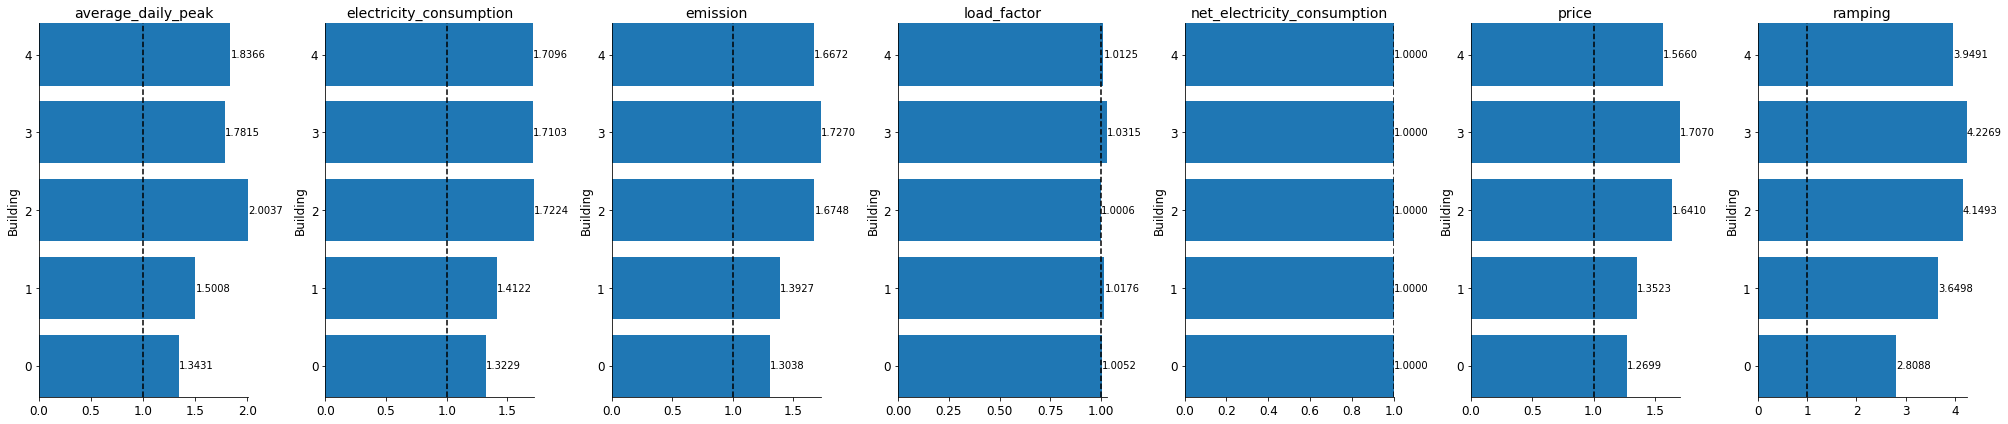

In [122]:
group_list = []
suffixes = ['', '_without_storage']

for suffix in suffixes:
    for (building_id, episode), group in deployment_strategy_3_0_building_detailed_summary.groupby(['building_id','episode']):
        group = group.copy()
        column = 'net_electricity_consumption' + suffix
        group['average_daily_peak'] = CostFunction.average_daily_peak(group[column])
        group['load_factor'] = CostFunction.load_factor(group[column])
        group['ramping'] = CostFunction.ramping(group[column])
        group['emission'] = CostFunction.carbon_emissions(group['net_electricity_consumption_emission'+suffix])
        group['price'] = CostFunction.price(group['net_electricity_consumption_price'+suffix])
        group['electricity_consumption'] = CostFunction.net_electricity_consumption(group[column])
        group['storage'] = 'without_storage' if 'without' in suffix else 'with_storage'
        group_list.append(group)

plot_data = pd.concat(group_list,ignore_index=True)
del group_list
plot_data = plot_data.melt(
    id_vars=['building_id','episode','time_step','storage'],
    value_vars=['average_daily_peak','load_factor','ramping','emission','price','electricity_consumption','net_electricity_consumption'],
    var_name='cost_function'
)
plot_data = plot_data.pivot_table(index=['building_id','episode','time_step','cost_function'],columns='storage',values='value')
plot_data = plot_data.reset_index()
plot_data['score'] = plot_data['with_storage']/plot_data['without_storage']

row_count = len(plot_data['cost_function'].unique())
column_count = 1
fig, axs = plt.subplots(row_count,column_count,figsize=(column_count*18,row_count*2))

for ax, (cost_function, cost_data) in zip(fig.axes, plot_data.groupby(['cost_function'])):
    for building_id, building_data in cost_data.groupby(['building_id']):
        building_data = building_data.sort_values(['episode','time_step'])
        x = building_data.reset_index().index
        y = building_data['score']
        ax.plot(x, y)
    
    ax.axhline(1,color='black',linestyle='--')
    ax.set_title(cost_function)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(cost_data['time_step'].max()))

plt.tight_layout()
plt.show()

# final score
final_data = plot_data[
    (plot_data['episode']==plot_data['episode'].max())
    &(plot_data['time_step']==plot_data['time_step'].max())
].copy()
row_count = 1
column_count = len(plot_data['cost_function'].unique())
fig, axs = plt.subplots(row_count,column_count,figsize=(column_count*4,row_count*6))

for ax, (cost_function, cost_data) in zip(fig.axes,final_data.groupby(['cost_function'])):
    y = cost_data['score']
    x = cost_data['building_id']
    rects = ax.barh(x,y)
    ax.bar_label(rects,fmt='%.4f',label_type='edge')
    ax.set_title(cost_function)
    ax.axvline(1.0,color='black',linestyle='--')
    ax.set_ylabel('Building')
    ax.set_yticks(x.tolist())
    ax.set_yticklabels(x.tolist())
    ax.spines[['right','top']].set_visible(False)

plt.tight_layout()
plt.show()

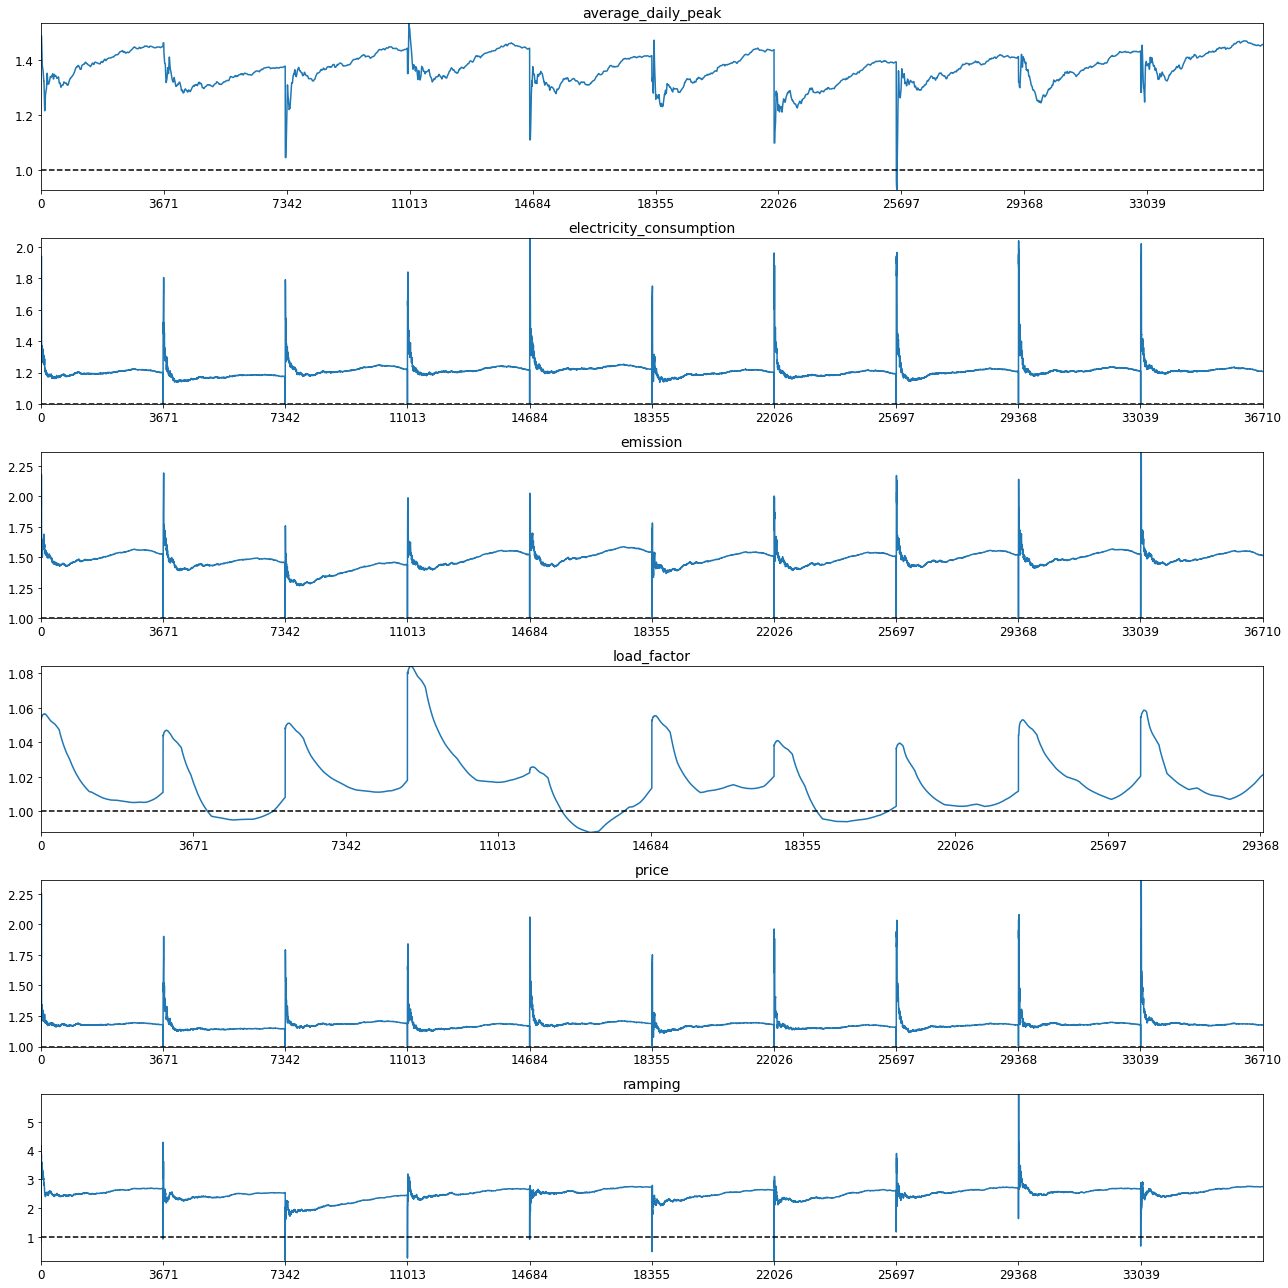

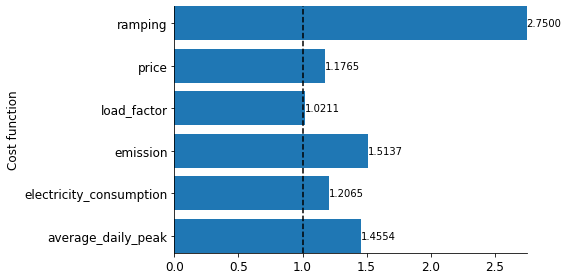

In [123]:
group_list = []
suffixes = ['', '_without_storage']

for suffix in suffixes:
    for episode, group in deployment_strategy_3_0_district_detailed_summary.groupby(['episode']):
        group = group.copy()
        column = 'net_electricity_consumption' + suffix
        group['average_daily_peak'] = CostFunction.average_daily_peak(group[column])
        group['load_factor'] = CostFunction.load_factor(group[column])
        group['ramping'] = CostFunction.ramping(group[column])
        group['emission'] = CostFunction.carbon_emissions(group['net_electricity_consumption_emission'+suffix])
        group['price'] = CostFunction.price(group['net_electricity_consumption_price'+suffix])
        group['electricity_consumption'] = CostFunction.net_electricity_consumption(group[column])
        group = group.melt(
            id_vars=['episode','time_step'],
            value_vars=['average_daily_peak','load_factor','ramping','emission','price','electricity_consumption'],
            var_name='cost_function'
        )
        group['column'] = column
        group_list.append(group)

plot_data = pd.concat(group_list,ignore_index=True)
del group_list
plot_data = plot_data.pivot_table(index=['episode','time_step','cost_function'],columns='column',values='value')
plot_data = plot_data.reset_index()
plot_data['score'] = plot_data['net_electricity_consumption']/plot_data['net_electricity_consumption_without_storage']

row_count = len(plot_data['cost_function'].unique())
column_count = 1
fig, axs = plt.subplots(row_count,column_count,figsize=(column_count*18,row_count*3))

for ax, (cost_function, cost_data) in zip(fig.axes, plot_data.groupby(['cost_function'])):
    cost_data = cost_data.sort_values(['episode','time_step'])
    x = cost_data.reset_index().index
    y = cost_data['score']
    ax.plot(x, y)
    ax.axhline(1,color='black',linestyle='--')
    ax.set_title(cost_function)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(cost_data['time_step'].max()))

plt.tight_layout()
plt.show()

# final score
final_data = plot_data[
    (plot_data['episode']==plot_data['episode'].max())
    &(plot_data['time_step']==plot_data['time_step'].max())
].copy()
row_count = 1
column_count = 1
fig, ax = plt.subplots(row_count,column_count,figsize=(column_count*8,row_count*4))
y = final_data['score']
x = final_data['cost_function']
rects = ax.barh(x,y)
ax.bar_label(rects,fmt='%.4f',label_type='edge')
ax.axvline(1.0,color='black',linestyle='--')
ax.set_ylabel('Cost function')
ax.set_yticks(x.tolist())
ax.set_yticklabels(x.tolist())
ax.spines[['right','top']].set_visible(False)

plt.tight_layout()
plt.show()

In [66]:
# # plot electricity consumption profiles
# # start_time_step = 
# timestamps = ('2016-10-01','2016-10-08')
# plot_data = deployment_strategy_3_0_last_episode[
#     (deployment_strategy_3_0_last_episode['timestamp'] > timestamps[0])
#     &(deployment_strategy_3_0_last_episode['timestamp'] < timestamps[1])
# ].copy()
# column_count = 2
# building_ids = plot_data['building_id'].unique().tolist()
# row_count = math.ceil(len(building_ids)/column_count)
# fig, axs = plt.subplots(row_count,column_count,figsize=(8.0*column_count,2.0*row_count))

# for ax, (building_id, building_data) in zip(fig.axes, plot_data.groupby('building_id')):
#     x = building_data['timestamp']

#     y1 = building_data['net_electricity_consumption']
#     ax.plot(x,y1,label='net')

#     y2 = building_data['net_electricity_consumption_without_storage']
#     ax.plot(x,y2,label='without_storage')

#     ax.set_title(building_id)
#     ax.legend()

# plt.tight_layout()
# plt.show()

# Miscellaneous

In [253]:
weather_data = pd.read_csv('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/buildsys_2022/data/citylearn_challenge_2022_phase_3/weather.csv')
weather_data['timestamp'] = TIMESTAMPS['timestamp']
weather_data['year'] = weather_data['timestamp'].dt.year
weather_data['month'] = weather_data['timestamp'].dt.month
weather_data['week'] = weather_data['timestamp'].dt.week
weather_data.groupby(['year','month','week'])[['Outdoor Drybulb Temperature [C]']].mean().sort_values()

Outdoor Drybulb Temperature [C]
year month week                                 
2016 8     31                          20.586905
           32                          20.213095
           33                          19.442262
           34                          20.129167
           35                          19.606944
     9     35                          19.939583
           36                          20.392857
           37                          19.066071
           38                          19.779167
           39                          19.968333
     10    39                          18.639583
           40                          18.815476
           41                          17.817857
           42                          18.713095
           43                          17.101786
           44                          17.937500
     11    44                          16.315972
           45                          18.036310
           46                          16.967857
           47                          15.060714
           48                          12.980556
     12    48                          16.492708
           49                          13.902976
           50                          14.052976
           51                          14.087500
           52                          13.943056
2017 1     1                           11.288095
           2                           12.572619
           3                           16.069643
           4                           15.064881
...                                          ...
     2     6                           13.505357
           7                           13.475595
           8                           14.721429
           9                           14.677083
     3     9                           15.622500
           10                          14.746429
           11                          13.561905
           12                          13.308929
           13                          16.409167
     4     13                          13.337500
           14                          15.808929
           15                          14.761310
           16                          15.345238
           17                          17.877976
     5     18                          15.726190
           19                          17.087500
           20                          17.527381
           21                          17.593452
           22                          16.893056
     6     22                          16.903125
           23                          17.917262
           24                          18.847619
           25                          18.500595
           26                          18.226667
     7     26                          20.014583
           27                          19.067262
           28                          19.123810
           29                          20.616071
           30                          20.349405
           31                          21.683333

[63 rows x 1 columns]

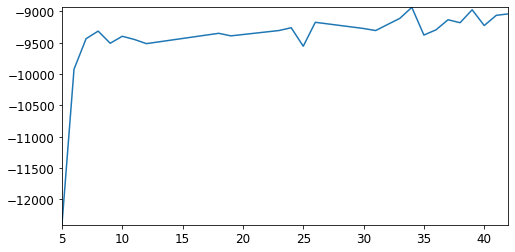

In [98]:
data_list = []
data_directory = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/buildsys_2022/data/single_building'
filenames = [f for f in os.listdir(data_directory) if f.startswith('episode')]

for f in filenames:
    d = pd.read_csv(os.path.join(data_directory,f))
    data_list.append(d)

data = pd.concat(data_list,ignore_index=True)
plot_data = data.groupby('episode')[['reward']].sum()
x, y = plot_data.index, plot_data['reward']
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(x,y)
plt.show()

In [94]:
directory = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/buildsys_2022/data/single_building'
filenames = [f for f in os.listdir(directory) if f.startswith('episode')]

for f in filenames:
    i = f.split('.')[0].split('_')[-1]
    os.rename(os.path.join(directory,f), os.path.join(directory, f.replace(i,str(int(int(i) - 5)))))
